# Dependencies Installation/Imports


In [ ]:
# Install the necessary dependencies
%pip install datasets
%pip install transformers
%pip install spacy
%pip install torch
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval
%pip install optuna
%pip install peft
%pip install accelerate -U
%pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-no

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

from transformers import AutoTokenizer, AutoModelForTokenClassification, BertForTokenClassification, BertConfig, RobertaForTokenClassification, RobertaConfig

from transformers import DataCollatorForTokenClassification

from transformers import AdamW, get_scheduler

from transformers.optimization import Adafactor, AdafactorSchedule

from torch.optim import SGD, Adam

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

import optuna

from optuna.samplers import GridSampler

import numpy as np

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from datasets import concatenate_datasets

from collections import defaultdict

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from datasets import DatasetDict

import seaborn as sns

from transformers import BertTokenizer, XLNetTokenizer, RobertaTokenizer

# Dataset Visualization




In [ ]:
# Load dataset
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
# Get the train, val, test datasets
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]
print(dataset)
print(sum(len(sample['tokens']) for sample in dataset['train']))
print(sum(len(sample['tokens']) for sample in dataset['validation']))
print(sum(len(sample['tokens']) for sample in dataset['test']))

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})
40000
5000
5000


45000
45000
Counter({'NOUN': 11272, 'PUNCT': 9909, 'PROPN': 4896, 'ADP': 3879, 'ADJ': 3613, 'VERB': 2938, 'DET': 2212, 'NUM': 1683, 'CCONJ': 1207, 'AUX': 1056, 'ADV': 658, 'PRON': 533, 'X': 346, 'PART': 324, 'SCONJ': 290, 'SYM': 183, 'INTJ': 1})
Counter({'B-O': 37232, 'I-LF': 3558, 'B-AC': 2599, 'B-LF': 1611})


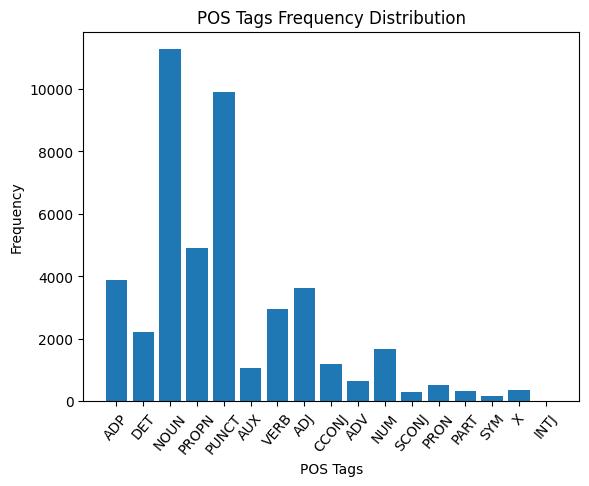

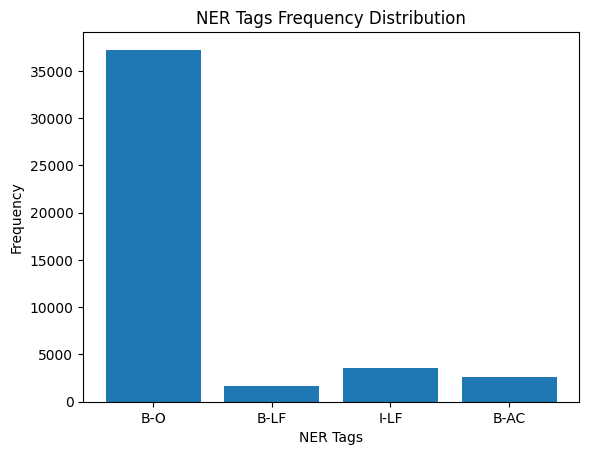

In [ ]:
# Do data visualization on the train and validation datasets
combined_dataset = concatenate_datasets([train_data, val_data])
pos_tags = [tag for list in combined_dataset['pos_tags'] for tag in list]
ner_tags = [tag for list in combined_dataset['ner_tags'] for tag in list]

# COunt the pos and ner tags in the datasets
pos_counter = Counter(pos_tags)
ner_counter = Counter(ner_tags)

print(len(pos_tags))
print(len(ner_tags))
print(pos_counter)
print(ner_counter)
pos_df = pd.DataFrame(list(pos_counter.items()), columns=['POS Tag', 'Frequency'])
ner_df = pd.DataFrame(list(ner_counter.items()), columns=['NER Tag', 'Frequency'])

# Graph the POS Tags Frequencies
plt.bar(pos_df['POS Tag'], pos_df['Frequency'])
plt.title('POS Tags Frequency Distribution')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=50)
plt.show()

# Graph the NER Tags Frequencies
plt.bar(ner_df['NER Tag'], ner_df['Frequency'])
plt.title('NER Tags Frequency Distribution')
plt.xlabel('NER Tags')
plt.ylabel('Frequency')
plt.show()


[15, 52, 30, 6, 41, 54, 26, 30, 33, 19, 36, 41, 34, 53, 35, 18, 28, 50, 60, 51, 49, 35, 29, 60, 21, 39, 26, 60, 76, 15, 14, 2, 24, 7, 23, 17, 29, 53, 28, 29, 61, 36, 27, 7, 34, 21, 21, 52, 33, 34, 30, 13, 21, 50, 25, 20, 28, 29, 31, 26, 45, 47, 37, 20, 36, 19, 20, 60, 64, 36, 16, 32, 21, 58, 22, 27, 9, 27, 23, 27, 33, 33, 61, 44, 56, 46, 20, 65, 37, 21, 31, 22, 31, 4, 39, 18, 12, 24, 17, 11, 18, 22, 14, 30, 24, 27, 19, 45, 14, 28, 7, 62, 41, 44, 35, 42, 48, 53, 28, 48, 31, 31, 25, 91, 165, 39, 20, 42, 64, 95, 5, 19, 58, 24, 21, 27, 22, 22, 47, 20, 16, 61, 22, 40, 38, 28, 33, 17, 46, 31, 35, 37, 33, 31, 29, 32, 81, 39, 31, 6, 70, 30, 43, 45, 19, 26, 6, 37, 18, 27, 57, 52, 42, 40, 12, 7, 44, 64, 21, 19, 33, 10, 4, 8, 23, 28, 61, 30, 6, 36, 51, 33, 25, 36, 26, 55, 35, 41, 39, 93, 38, 37, 27, 20, 42, 48, 43, 42, 48, 53, 39, 41, 23, 34, 53, 28, 19, 23, 82, 31, 55, 46, 28, 50, 49, 42, 27, 22, 28, 48, 19, 31, 24, 5, 62, 53, 14, 23, 29, 43, 46, 58, 6, 22, 53, 19, 43, 52, 58, 44, 40, 36, 18, 58

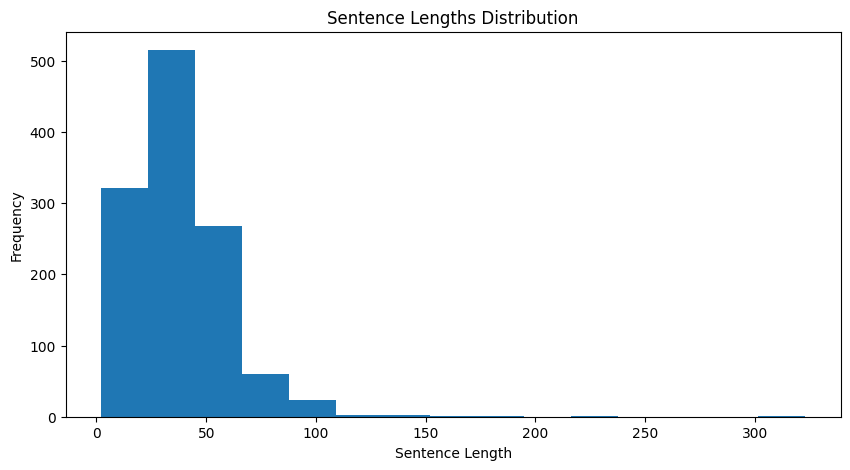

Bin 1 (2.0 - 23.4): 26.79%
Bin 2 (23.4 - 44.8): 42.99%
Bin 3 (44.8 - 66.19999999999999): 22.37%
Bin 4 (66.19999999999999 - 87.6): 5.01%
Bin 5 (87.6 - 109.0): 2.00%
Bin 6 (109.0 - 130.39999999999998): 0.25%
Bin 7 (130.39999999999998 - 151.79999999999998): 0.25%
Bin 8 (151.79999999999998 - 173.2): 0.08%
Bin 9 (173.2 - 194.6): 0.08%
Bin 10 (194.6 - 216.0): 0.00%
Bin 11 (216.0 - 237.39999999999998): 0.08%
Bin 12 (237.39999999999998 - 258.79999999999995): 0.00%
Bin 13 (258.79999999999995 - 280.2): 0.00%
Bin 14 (280.2 - 301.59999999999997): 0.00%
Bin 15 (301.59999999999997 - 323.0): 0.08%


In [ ]:
# Graph for sentence lengths
sentence_lengths = [len(sentence) for sentence in combined_dataset['tokens']]
#print(sentence_lengths)

# Graph the data
plt.figure(figsize=(10, 5))
counts, bin_edges, _ = plt.hist(sentence_lengths, bins=15)
plt.title('Sentence Lengths Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

# Calculate the percentages of sentences within each bin
total_sentences = len(sentence_lengths)
bin_percentages = [(count / total_sentences) * 100 for count in counts]
for i in range(len(bin_edges) - 1):
    print(f"Bin {i + 1} ({bin_edges[i]} - {bin_edges[i+1]}): {bin_percentages[i]:.2f}%")

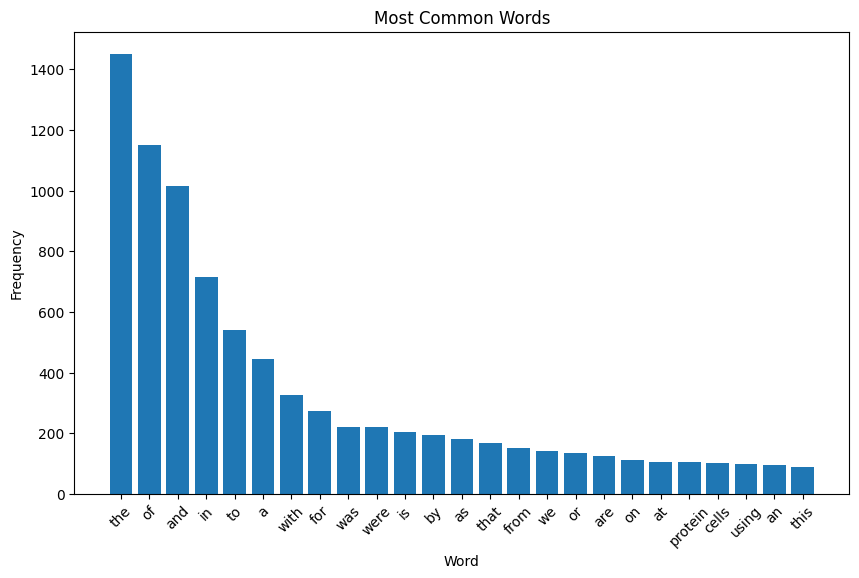

In [ ]:
# Most common words in the dataset
all_tokens = [token.lower() for sublist in combined_dataset['tokens'] for token in sublist if token.isalpha()]
word_counts = Counter(all_tokens)
most_common_words = word_counts.most_common(25)

# Plot the data
words, frequencies = zip(*most_common_words)
plt.figure(figsize=(10,6))
plt.bar(words, frequencies)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.show()


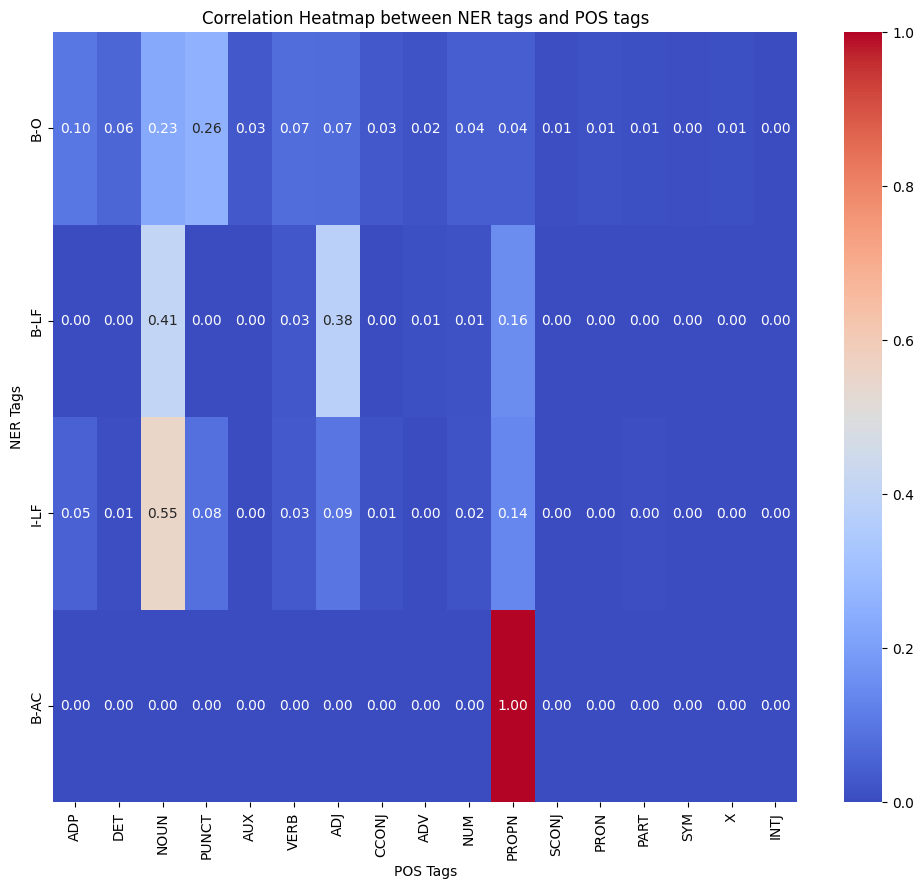

In [ ]:
# Correlation heatmap for NER and POS tags
co_occurrence = defaultdict(lambda: defaultdict(int))

# Count the correlations between the tags
for pos_tags, ner_tags in zip(combined_dataset['pos_tags'], combined_dataset['ner_tags']):
    for pos_tag, ner_tag in zip(pos_tags, ner_tags):
        co_occurrence[ner_tag][pos_tag] += 1
co_occurrence_df = pd.DataFrame(co_occurrence).fillna(0).T

# Normalize the rows
co_occurrence_df = co_occurrence_df.div(co_occurrence_df.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(10, 9))
sns.heatmap(co_occurrence_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between NER tags and POS tags')
plt.xlabel('POS Tags')
plt.ylabel('NER Tags')
plt.show()

In [ ]:
# Flatten lists
words = [word for sublist in combined_dataset['tokens'] for word in sublist]
ner_tags = [tag for sublist in combined_dataset['ner_tags'] for tag in sublist]

# Create DataFrame
df = pd.DataFrame({'Word': words, 'Tag': ner_tags})

# Filter for relevant tags and calculate lengths
df['Length'] = df['Word'].apply(len)
long_form = df[df['Tag'].isin(['B-LF', 'I-LF'])]
acronym = df[df['Tag'] == 'B-AC']

# Calculate average lengths
avg_length_long_form = long_form['Length'].mean()
avg_length_acronym = acronym['Length'].mean()

# Data for plotting
categories = ['Long Form (B-LF, I-LF)', 'Acronym (B-AC)']
averages = [avg_length_long_form, avg_length_acronym]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, averages, color=['blue', 'green'])
plt.xlabel('Entity Types')
plt.ylabel('Average Word Length')
plt.title('Average Word Length by Entity Type')
plt.ylim(0, max(averages) + 1)  # Add some space above the tallest bar
plt.show()


In [ ]:
# Label definitions
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}
label_list = ['B-O', 'B-AC', 'B-LF', 'I-LF']

# Label lists
train_label_list = []
for sample in train_data["ner_tags"]:
    train_label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in val_data["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in test_data["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])

# Data Pre-Processing

#### Tokenize and Align Labels

In [ ]:
# Function for tokenizing and aligning the labels into 1 list
def tokenize_and_align_labels(short_dataset, list_name, tokenizer_name):
    # RoBERTa needs the add_prefix_space to be set to True
    if tokenizer_name == "roberta-base":
      tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, add_prefix_space=True)
    else:
      tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    # Tokenize all the inputs
    tokenized_inputs = tokenizer(short_dataset["tokens"], truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    # Add the labels to the labels list
    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        #print(f"Label: {len(label)}")
        #print(f"Word: {len(word_ids)}")
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Tokenize and align the labels for the 3 transformer models to be tested
tokenized_train_data = tokenize_and_align_labels(train_data, train_label_list, "bert-base-cased")
tokenized_val_data = tokenize_and_align_labels(val_data, val_label_list, "bert-base-cased")
tokenized_test_data = tokenize_and_align_labels(test_data, test_label_list, "bert-base-cased")

tokenized_train_roberta = tokenize_and_align_labels(train_data, train_label_list, "roberta-base")
tokenized_val_roberta = tokenize_and_align_labels(val_data, val_label_list, "roberta-base")
tokenized_test_roberta = tokenize_and_align_labels(test_data, test_label_list, "roberta-base")

tokenized_train_xlnet = tokenize_and_align_labels(train_data, train_label_list, "xlnet-base-cased")
tokenized_val_xlnet = tokenize_and_align_labels(val_data, val_label_list, "xlnet-base-cased")
tokenized_test_xlnet = tokenize_and_align_labels(test_data, test_label_list, "xlnet-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Import the tokenizers

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
print(tokenizer.tokenize("This is a test of different tokenizers"))

tokenizer = XLNetTokenizer.from_pretrained("xlnet/xlnet-base-cased")
print(tokenizer.tokenize("This is a test of different tokenizers"))

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
print(tokenizer.tokenize("This is a test of different tokenizers"))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

['this', 'is', 'a', 'test', 'of', 'different', 'token', '##izer', '##s']


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

['▁This', '▁is', '▁a', '▁test', '▁of', '▁different', '▁token', 'izer', 's']
['This', 'Ġis', 'Ġa', 'Ġtest', 'Ġof', 'Ġdifferent', 'Ġtoken', 'izers']


In [ ]:
print(train_data[0:10])

{'tokens': [['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.'], ['The', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'gs', ',', 'mol', 'H2O', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'E', ',', 'mmol', 'H2O', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'PN', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'CO2', 'concentration', 'CO2', '(', 'Ci', ',', 'μmol', 'm-2', 's-1', ')', '.'], ['Minor', 'H', 'antigen', 'alloimmune', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'HLA)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'SCT', ')', '[', '3,4', ']', '.'], ['EPI', '=', 'Echo', 'planar', 'imaging', '.'], ['Furthermore', ',', 'eNOS', '-', 'derived', 'NO', 'S', '-', 'nitrosylated', 'β', '-', 'actin', 'on', 'Cys374', 'and', 

In [ ]:
# BERT's tokenizer returns the dataset in the form of a dictionary of lists (sentences).
# we have to convert it into a list of dictionaries for training.
def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list

In [ ]:
# Turn all the dictionaries of lists to lists of dictionaries
ready_train_data = turn_dict_to_list_of_dict(tokenized_train_data)
ready_val_data = turn_dict_to_list_of_dict(tokenized_val_data)
ready_test_data = turn_dict_to_list_of_dict(tokenized_test_data)

ready_train_roberta = turn_dict_to_list_of_dict(tokenized_train_roberta)
ready_val_roberta = turn_dict_to_list_of_dict(tokenized_val_roberta)
ready_test_roberta = turn_dict_to_list_of_dict(tokenized_test_roberta)

ready_train_xlnet = turn_dict_to_list_of_dict(tokenized_train_xlnet)
ready_val_xlnet = turn_dict_to_list_of_dict(tokenized_val_xlnet)
ready_test_xlnet = turn_dict_to_list_of_dict(tokenized_test_xlnet)


In [ ]:
# Check the amounts of tokens in each dataset
print(len(ready_test_data))
print(len(ready_test_roberta))
print(len(ready_test_xlnet))
bert_counter = 0
roberta_counter = 0
xlnet_counter = 0
for i in range(len(ready_test_roberta)):
  for i in range(len(ready_test_roberta[i]["input_ids"])):
    roberta_counter+=1
for i in range(len(ready_test_xlnet)):
  for i in range(len(ready_test_xlnet[i]["input_ids"])):
    xlnet_counter+=1
for i in range(len(ready_test_data)):
  for i in range(len(ready_test_data[i]["input_ids"])):
    bert_counter+=1

print(bert_counter)
print(xlnet_counter)
print(roberta_counter)



153
153
153
7403
8475
6816


In [ ]:
# Function for computing metrics

metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

<ipython-input-20-8f63e9058972>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


#### Prepare Lemmatization Dataset

In [ ]:
# Download NLTK libraries
nltk.download("wordnet")
nltk.download("omw-1.4")

# WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert our POS tags to the ones used by WordNet
def custom_to_wordnet_pos(custom_pos):
    if custom_pos in ["ADJ"]:
        return wordnet.ADJ
    elif custom_pos in ["VERB"]:
        return wordnet.VERB
    elif custom_pos in ["NOUN", "PROPN"]:
        return wordnet.NOUN
    elif custom_pos in ["ADV"]:
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for lemmatizing tokens
def lemmatize_tokens(tokens, pos_tags):
    lemmatized_tokens = []
    for token, pos_tag in zip(tokens, pos_tags):
        wordnet_pos = custom_to_wordnet_pos(pos_tag)
        lemmatized_tokens.append(lemmatizer.lemmatize(token, wordnet_pos))
    return lemmatized_tokens


# Apply the lemmatization function to the dataset
lemma_train_data = train_data.map(lambda x: {"tokens": lemmatize_tokens(x["tokens"], x["pos_tags"])})
lemma_val_data = val_data.map(lambda x: {"tokens": lemmatize_tokens(x["tokens"], x["pos_tags"])})
lemma_test_data = test_data.map(lambda x: {"tokens": lemmatize_tokens(x["tokens"], x["pos_tags"])})

print(train_data[10]["tokens"])
print(lemma_train_data[10]["tokens"])

# Apply lemmtization using RoBERTa as it was the best performer in the later experiments
tokenized_lemma_train = tokenize_and_align_labels(lemma_train_data, train_label_list, "roberta-base")
tokenized_lemma_val = tokenize_and_align_labels(lemma_val_data, val_label_list, "roberta-base")
tokenized_lemma_test = tokenize_and_align_labels(lemma_test_data, test_label_list, "roberta-base")

ready_lemma_train = turn_dict_to_list_of_dict(tokenized_lemma_train)
ready_lemma_val = turn_dict_to_list_of_dict(tokenized_lemma_val)
ready_lemma_test = turn_dict_to_list_of_dict(tokenized_lemma_test)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
Parameter 'function'=<function <lambda> at 0x7fe08059f5b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

['DHI', 'was', 'significantly', 'correlated', 'to', 'PCL', 'scores', ',', 'suggesting', 'that', 'Veterans', 'with', 'more', 'severe', 'PTSD', 'symptoms', 'also', 'had', 'more', 'dizziness', 'handicap', 'as', 'illustrated', 'in', 'Fig', '2', '(', 'r2', '=', '0.28', ',', 'p', '<', '0.0001', ')', '.']
['DHI', 'wa', 'significantly', 'correlate', 'to', 'PCL', 'score', ',', 'suggest', 'that', 'Veterans', 'with', 'more', 'severe', 'PTSD', 'symptom', 'also', 'have', 'more', 'dizziness', 'handicap', 'a', 'illustrate', 'in', 'Fig', '2', '(', 'r2', '=', '0.28', ',', 'p', '<', '0.0001', ')', '.']


In [ ]:
print(train_data[5]["tokens"])
print(lemma_train_data[5]["tokens"])

['The', 'importance', 'of', 'NO', 'and', 'the', 'formation', 'of', 'PFN1', '-', 'actin', 'complexes', 'on', 'the', 'regulation', 'of', 'PKC', 'was', 'corroborated', 'by', 'overexpression', 'of', '-θPFN1-', 'and', 'actin', '-', 'binding', 'defective', 'mutants', 'of', 'β', '-', 'actin', '(', 'C374S', ')', 'and', 'PFN1', '(', 'H119E', ')', ',', 'respectively', ',', 'which', 'reduced', 'the', 'coalescence', 'of', 'PKC', 'at', 'the', '-θc-SMAC', '.']
['The', 'importance', 'of', 'NO', 'and', 'the', 'formation', 'of', 'PFN1', '-', 'actin', 'complex', 'on', 'the', 'regulation', 'of', 'PKC', 'wa', 'corroborate', 'by', 'overexpression', 'of', '-θPFN1-', 'and', 'actin', '-', 'bind', 'defective', 'mutant', 'of', 'β', '-', 'actin', '(', 'C374S', ')', 'and', 'PFN1', '(', 'H119E', ')', ',', 'respectively', ',', 'which', 'reduce', 'the', 'coalescence', 'of', 'PKC', 'at', 'the', '-θc-SMAC', '.']


#### Prepare Stemmed Dataset

In [ ]:
# Download NLTK libraries
nltk.download("punkt")

# orter Stemmer
stemmer = PorterStemmer()

# Function to stem the tokens
def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens


# Apply the stemming function to the dataset
stem_train_data = train_data.map(lambda x: {"tokens": stem_tokens(x["tokens"])})
stem_val_data = val_data.map(lambda x: {"tokens": stem_tokens(x["tokens"])})
stem_test_data = test_data.map(lambda x: {"tokens": stem_tokens(x["tokens"])})

# Apply lemmtization using RoBERTa as it was the best performer in the later experiments
tokenized_stem_train = tokenize_and_align_labels(stem_train_data, train_label_list, "roberta-base")
tokenized_stem_val = tokenize_and_align_labels(stem_val_data, val_label_list, "roberta-base")
tokenized_stem_test = tokenize_and_align_labels(stem_test_data, test_label_list, "roberta-base")

ready_stem_train = turn_dict_to_list_of_dict(tokenized_stem_train)
ready_stem_val = turn_dict_to_list_of_dict(tokenized_stem_val)
ready_stem_test = turn_dict_to_list_of_dict(tokenized_stem_test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
# Print the dataset with stemmed tokens
print(train_data[10]["tokens"])
print(stem_train_data[10]["tokens"])

['DHI', 'was', 'significantly', 'correlated', 'to', 'PCL', 'scores', ',', 'suggesting', 'that', 'Veterans', 'with', 'more', 'severe', 'PTSD', 'symptoms', 'also', 'had', 'more', 'dizziness', 'handicap', 'as', 'illustrated', 'in', 'Fig', '2', '(', 'r2', '=', '0.28', ',', 'p', '<', '0.0001', ')', '.']
['dhi', 'wa', 'significantli', 'correl', 'to', 'pcl', 'score', ',', 'suggest', 'that', 'veteran', 'with', 'more', 'sever', 'ptsd', 'symptom', 'also', 'had', 'more', 'dizzi', 'handicap', 'as', 'illustr', 'in', 'fig', '2', '(', 'r2', '=', '0.28', ',', 'p', '<', '0.0001', ')', '.']


In [ ]:
counter = 0
for i in range(len(tokenized_lemma_test["input_ids"])):
    counter+=len(tokenized_lemma_test["input_ids"][i])
print(counter)

counter = 0
for i in range(len(tokenized_stem_test["input_ids"])):
    counter+=len(tokenized_stem_test["input_ids"][i])
print(counter)

6804
7160


# Experiment 1: Different Pre-Trained Models

### Experiment 1.1 BERT

In [ ]:
# Import the tokenizer, model, and data collator
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=4)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Training arguments (feel free to play arround with these values)
model_name = "bert-base-cased"
epochs = 6
batch_size = 4
learning_rate = 1e-5

# Training args
args = TrainingArguments(
    f"BERT-finetuned-NER",
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

# Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=ready_train_data,
    eval_dataset=ready_val_data,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.2093786831518904, metrics={'train_runtime': 75.513, 'train_samples_per_second': 85.177, 'train_steps_per_second': 21.294, 'total_flos': 298661469069024.0, 'train_loss': 0.2093786831518904, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.96      0.95      0.96      5668
        B-AC       0.79      0.80      0.79       650
        B-LF       0.73      0.81      0.77       322
        I-LF       0.77      0.85      0.81       457

    accuracy                           0.92      7097
   macro avg       0.81      0.85      0.83      7097
weighted avg       0.92      0.92      0.92      7097

0.921516133577568
0.9225406809267658
[[5371  135   72   90]
 [ 127  520    0    3]
 [  41    1  260   20]
 [  40    3   25  389]]


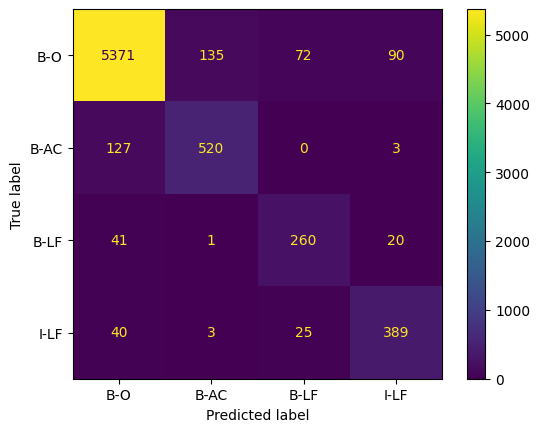

In [ ]:


# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_test_data)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out the reports
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()



In [ ]:
# Prepare the test data for evaluation in the same format as the training data
trainer.evaluate()

{'eval_loss': 0.2383965402841568,
 'eval_precision': 0.9386696021387011,
 'eval_recall': 0.9344082654978084,
 'eval_f1': 0.9365340864517141,
 'eval_accuracy': 0.9319560820572089,
 'eval_runtime': 0.6082,
 'eval_samples_per_second': 207.176,
 'eval_steps_per_second': 52.616,
 'epoch': 6.0}

### Experiment 1.2 XLNet

In [ ]:
# Import tokenizer, model, and data collator
xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
xlnet_model = AutoModelForTokenClassification.from_pretrained("xlnet-base-cased", num_labels=4)
data_collator = DataCollatorForTokenClassification(xlnet_tokenizer)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

model_name = "xlnet-base-cased"
epochs = 6
batch_size = 4
learning_rate = 1e-5

xlnet_args = TrainingArguments(
    f"XLNet-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

xlnet_trainer = Trainer(
    xlnet_model,
    xlnet_args,
    train_dataset=ready_train_xlnet,
    eval_dataset=ready_val_xlnet,
    data_collator = data_collator,
    tokenizer=xlnet_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)
xlnet_trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.2259493840867607, metrics={'train_runtime': 102.5817, 'train_samples_per_second': 62.701, 'train_steps_per_second': 15.675, 'total_flos': 374546773391232.0, 'train_loss': 0.2259493840867607, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      6708
        B-AC       0.86      0.83      0.84       670
        B-LF       0.77      0.81      0.79       314
        I-LF       0.81      0.90      0.85       477

    accuracy                           0.94      8169
   macro avg       0.85      0.88      0.86      8169
weighted avg       0.95      0.94      0.94      8169

0.9443016281062554
0.9447740687786941
[[6471   94   58   85]
 [ 106  558    2    4]
 [  44    0  255   15]
 [  30    0   17  430]]


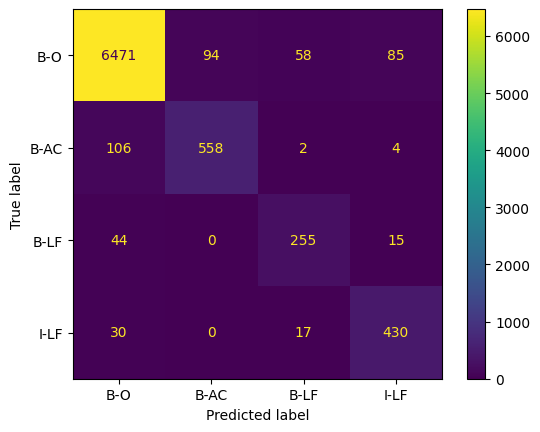

In [ ]:
# Code to generate predictions and labels
predictions, labels, _ = xlnet_trainer.predict(ready_test_xlnet)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]


print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()

In [ ]:
xlnet_trainer.evaluate()

{'eval_loss': 0.22444464266300201,
 'eval_precision': 0.9458871515975527,
 'eval_recall': 0.943322033898305,
 'eval_f1': 0.9446028513238289,
 'eval_accuracy': 0.9391993957703928,
 'eval_runtime': 0.9024,
 'eval_samples_per_second': 139.635,
 'eval_steps_per_second': 35.463,
 'epoch': 6.0}

### Experiment 1.3 RoBERTa

In [ ]:
# Import tokenizer, model, and data collator
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Training arguments (feel free to play arround with these values)
model_name = "roberta-base"
epochs = 6
batch_size = 4
learning_rate = 1e-5

args = TrainingArguments(
    f"RoBERTa-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=ready_train_roberta,
    eval_dataset=ready_val_roberta,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.19577749807443193, metrics={'train_runtime': 75.9016, 'train_samples_per_second': 84.741, 'train_steps_per_second': 21.185, 'total_flos': 272841616431072.0, 'train_loss': 0.19577749807443193, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5274
        B-AC       0.82      0.85      0.84       559
        B-LF       0.77      0.88      0.82       288
        I-LF       0.79      0.91      0.84       389

    accuracy                           0.94      6510
   macro avg       0.84      0.90      0.87      6510
weighted avg       0.94      0.94      0.94      6510

0.9385560675883257
0.9397511299120602
[[5029   99   67   79]
 [  79  475    3    2]
 [  21    0  253   14]
 [  26    3    7  353]]


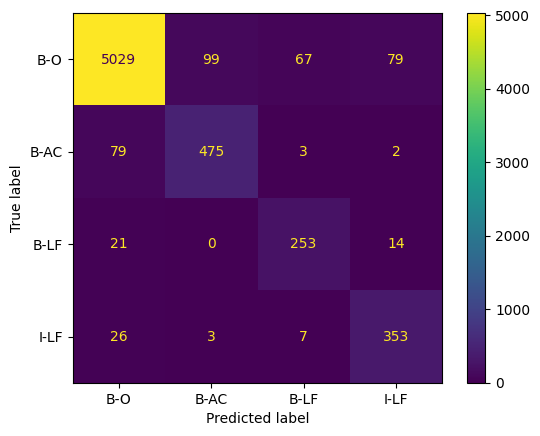

In [ ]:


# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_test_roberta)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]


print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()

### Experiment 1 Results Visualization

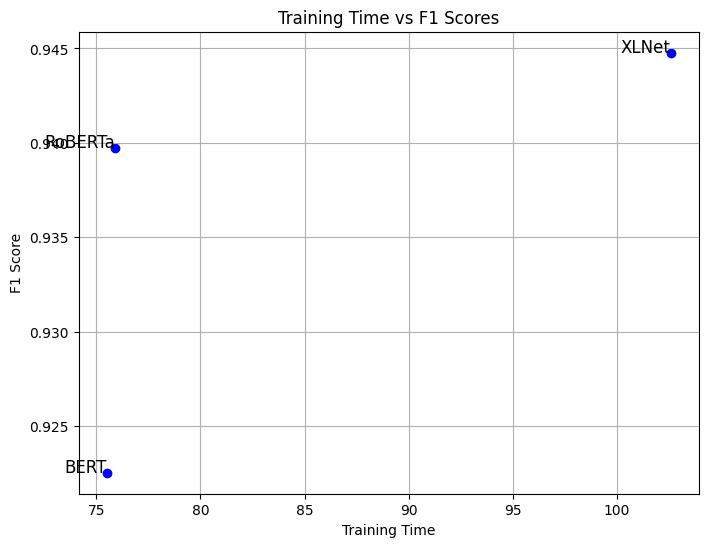

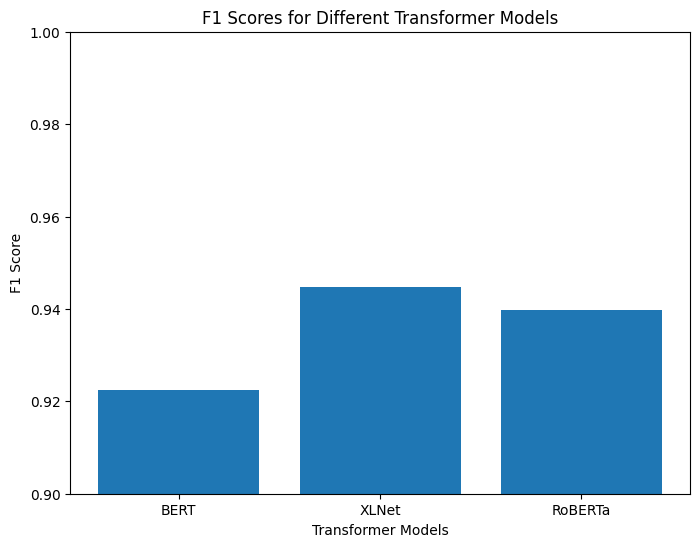

In [ ]:
from matplotlib import pyplot as plt

# Data from experiment
train_runtime = [75.513, 102.5817, 75.9016]
f1_scores = [0.9225406809267658,0.9447740687786941,0.9397511299120602]

# Model names
model_names = ['BERT', 'XLNet', 'RoBERTa']

# create scatter plot and plot the data
plt.figure(figsize=(8, 6))
plt.scatter(train_runtime, f1_scores, color='b', label='Models')
for i in range(3):
    plt.text(train_runtime[i], f1_scores[i], model_names[i], fontsize=12, ha='right')

# Label the graph
plt.xlabel('Training Time')
plt.ylabel('F1 Score')
plt.title('Training Time vs F1 Scores')
plt.grid(True)
plt.show()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores)
plt.ylim(0.9,1)

# Label the graph
plt.xlabel('Transformer Models')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Different Transformer Models')
plt.show()


# Experiment 2: Pre-Processed Datasets

#### Experiment 2.1 No Pre-Procesing

In [ ]:
#Same as experiment 1.1

#### Experiment 2.2 Lemmatization Dataset

In [ ]:
# Import tokenizer model, and data collator
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Training arguments (feel free to play arround with these values)
epochs = 6
batch_size = 4
learning_rate = 1e-5

# Training args
args = TrainingArguments(
    f"BERT-finetuned-NER",
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

# Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=ready_lemma_train,
    eval_dataset=ready_lemma_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.20742689317731716, metrics={'train_runtime': 82.814, 'train_samples_per_second': 77.668, 'train_steps_per_second': 19.417, 'total_flos': 272482326894048.0, 'train_loss': 0.20742689317731716, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5262
        B-AC       0.81      0.84      0.82       559
        B-LF       0.74      0.85      0.79       289
        I-LF       0.78      0.93      0.85       388

    accuracy                           0.93      6498
   macro avg       0.83      0.89      0.86      6498
weighted avg       0.94      0.93      0.94      6498

0.9339796860572483
0.9354109102980471
[[4995  106   79   82]
 [  87  468    2    2]
 [  24    0  246   19]
 [  19    4    5  360]]


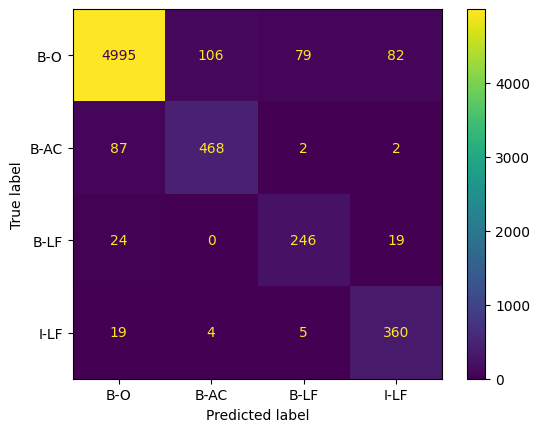

In [ ]:


# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_lemma_test)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out the graphs
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()

#### Exerpiment 2.3 Stemmed Dataset

In [ ]:
# Import tokenizer, model, and data collator
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Training arguments (feel free to play arround with these values)
model_name = "bert-base-cased"
epochs = 6
batch_size = 4
learning_rate = 1e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=ready_stem_train,
    eval_dataset=ready_stem_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.2439429202483068, metrics={'train_runtime': 83.2944, 'train_samples_per_second': 77.22, 'train_steps_per_second': 19.305, 'total_flos': 289050473953632.0, 'train_loss': 0.2439429202483068, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.97      0.94      0.96      5565
        B-AC       0.76      0.83      0.79       555
        B-LF       0.73      0.83      0.77       300
        I-LF       0.75      0.90      0.82       434

    accuracy                           0.93      6854
   macro avg       0.80      0.87      0.83      6854
weighted avg       0.93      0.93      0.93      6854

0.9250072950102131
0.9271064515310827
[[5242  143   75  105]
 [  91  458    0    6]
 [  30    0  249   21]
 [  20    4   19  391]]


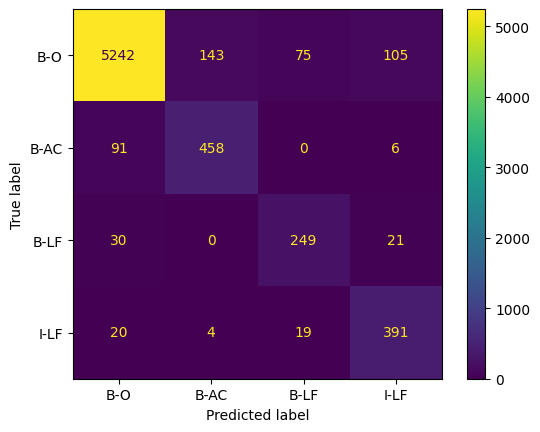

In [ ]:


# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_stem_test)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out reports
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()

### Experiment 2 Results Visualization

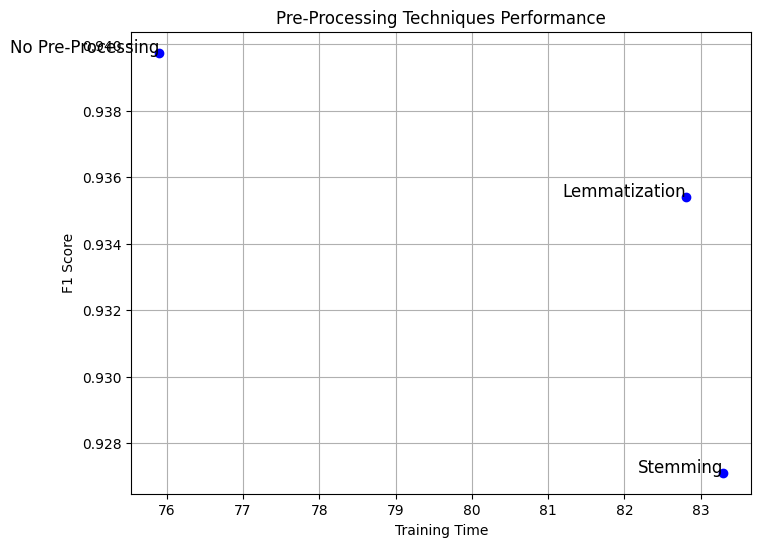

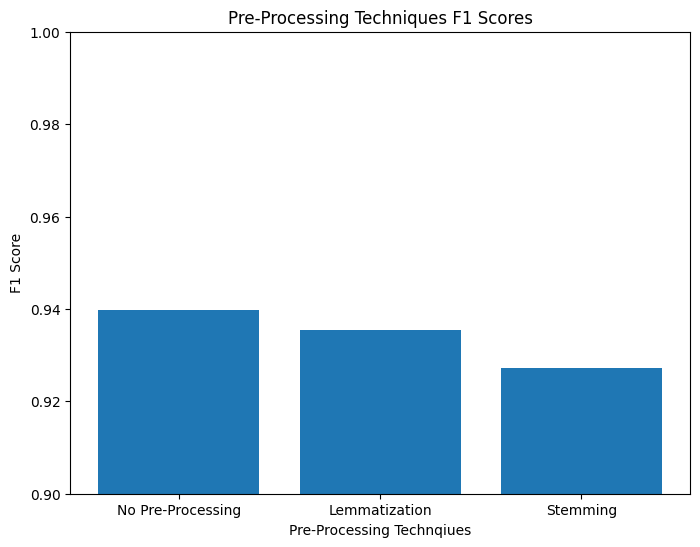

In [ ]:


# Data for experiment
train_runtime = [75.9016, 82.814, 83.2944]
f1_scores = [0.9397511299120602,0.9354109102980471,0.9271064515310827]

# Names of the different experiments/models
model_names = ['No Pre-Processing', 'Lemmatization', 'Stemming']

# Create plot and plot the data
plt.figure(figsize=(8, 6))
plt.scatter(train_runtime, f1_scores, color='b', label='Pre-Processing Technqiues')
for i in range(3):
    plt.text(train_runtime[i], f1_scores[i], model_names[i], fontsize=12, ha='right')

# Label the graph
plt.xlabel('Training Time')
plt.ylabel('F1 Score')
plt.title('Pre-Processing Techniques Performance')
plt.grid(True)
plt.show()

# Bar chart for f1 scores
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores)
plt.ylim(0.9,1)

# Label bar graph
plt.xlabel('Pre-Processing Technqiues')
plt.ylabel('F1 Score')
plt.title('Pre-Processing Techniques F1 Scores')
plt.show()


# Experiment 3: Pre-Trained BERT Model vs Training From Scratch BERT Model

### Experiment 3.1 Pre-Trained BERT Model

In [ ]:
#Same as experiment 1.1

### Experiment 3.2 Training From Scratch BERT Model

In [ ]:
# Import tokenizer, model, and data collator
# Training arguments (feel free to play arround with these values)
model_name = "bert-base-cased"
epochs = 6
batch_size = 4
learning_rate = 1e-5

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

data_collator = DataCollatorForTokenClassification(tokenizer)
# Initialize a bertconfig to train model from scratch
config = BertConfig(vocab_size=30522,
                    num_labels=4)
bert_model_scratch = BertForTokenClassification(config=config)

scratch_args = TrainingArguments(
    f"BERT-scartch-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)
scratch_trainer = Trainer(
    bert_model_scratch,
    scratch_args,
    train_dataset=ready_train_data,
    eval_dataset=ready_val_data,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
)
scratch_trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.6169567179324021, metrics={'train_runtime': 77.5087, 'train_samples_per_second': 82.984, 'train_steps_per_second': 20.746, 'total_flos': 298661469069024.0, 'train_loss': 0.6169567179324021, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.86      0.93      0.89      5668
        B-AC       0.57      0.57      0.57       650
        B-LF       0.27      0.06      0.09       322
        I-LF       0.37      0.18      0.24       457

    accuracy                           0.81      7097
   macro avg       0.52      0.43      0.45      7097
weighted avg       0.77      0.81      0.79      7097

0.8117514442722277
0.7866103920999055
[[5292  242   27  107]
 [ 259  368    6   17]
 [ 271   13   18   20]
 [ 338   20   16   83]]


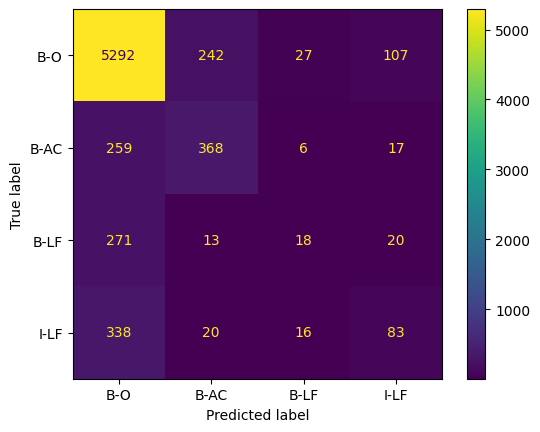

In [ ]:


# Code to generate predictions and labels
predictions, labels, _ = scratch_trainer.predict(ready_test_data)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out reports
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()



### Experiment 3.3 Fine-Tuning With LoRA

In [ ]:
# Import tokenizer, model, and data collator
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=4)
data_collator = DataCollatorForTokenClassification(tokenizer)

# Intialize Lora parameters
peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS , inference_mode=False, r=128, lora_alpha=128, lora_dropout=0.05
)

# Convert the transformer model into a LoRA model by applying the LoraConfig
model = get_peft_model(model, peft_config)



# Training arguments (feel free to play arround with these values)
epochs = 6
batch_size = 4
learning_rate = 1e-5

args = TrainingArguments(
    output_dir = f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=ready_train_data,
    eval_dataset=ready_val_data,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.5339191042961766, metrics={'train_runtime': 67.2472, 'train_samples_per_second': 95.647, 'train_steps_per_second': 23.912, 'total_flos': 315240303070656.0, 'train_loss': 0.5339191042961766, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.95      0.94      0.94      5668
        B-AC       0.70      0.79      0.74       650
        B-LF       0.71      0.02      0.03       322
        I-LF       0.49      0.81      0.61       457

    accuracy                           0.87      7097
   macro avg       0.71      0.64      0.58      7097
weighted avg       0.89      0.87      0.86      7097

0.8738903762153022
0.8616389777498419
[[5311  208    0  149]
 [ 133  515    1    1]
 [  83    5    5  229]
 [  76    9    1  371]]


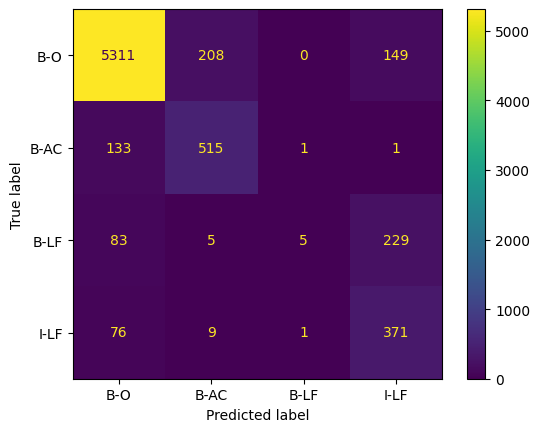

In [ ]:

# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_test_data)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out reports
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()



### Experiment 3 Results Visualization

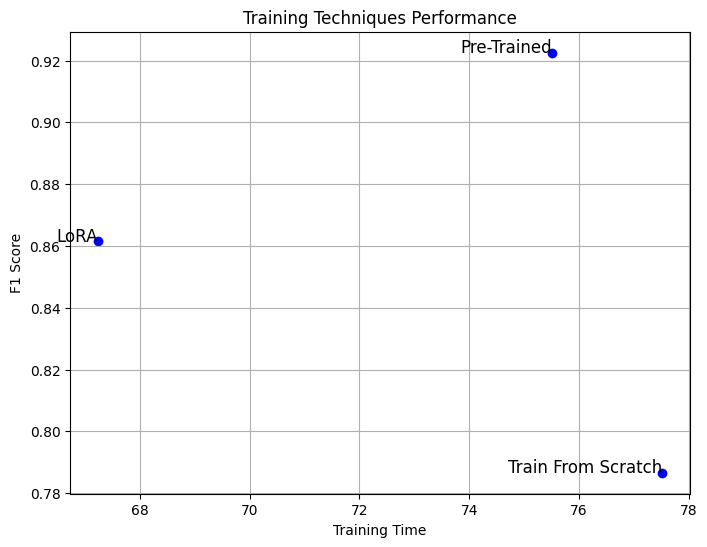

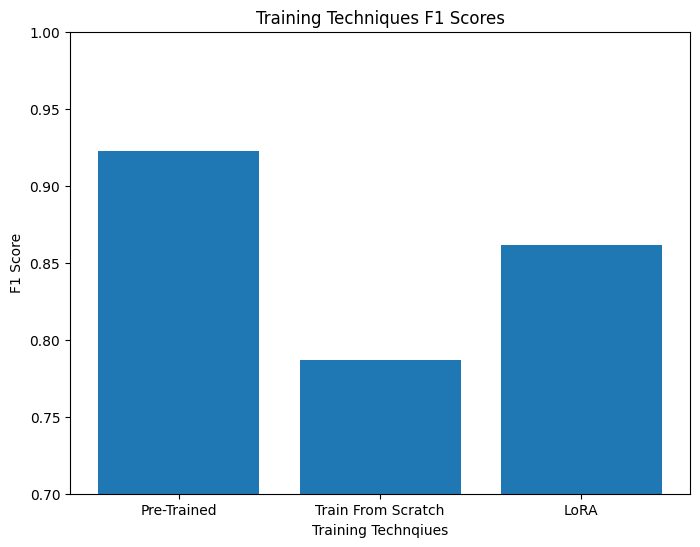

In [ ]:
# Data for experiment
train_runtime = [75.513, 77.5087, 67.2472]
f1_scores = [0.9225406809267658,0.7866103920999055,0.8616389777498419]

# Names of the different experiments/models
model_names = ['Pre-Trained', 'Train From Scratch', 'LoRA']

# Create plot and plot the data
plt.figure(figsize=(8, 6))
plt.scatter(train_runtime, f1_scores, color='b', label='Training Techniques')
for i in range(3):
    plt.text(train_runtime[i], f1_scores[i], model_names[i], fontsize=12, ha='right')

# Label the graph
plt.xlabel('Training Time')
plt.ylabel('F1 Score')
plt.title('Training Techniques Performance')
plt.grid(True)
plt.show()

# Bar chart for f1 scores
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores)
plt.ylim(0.7,1)

# Label bar graph
plt.xlabel('Training Technqiues')
plt.ylabel('F1 Score')
plt.title('Training Techniques F1 Scores')
plt.show()


# Experiment 4: Hyper-Parameter Tuning

#### Experiment 4.1: Optimizers

##### Experiment 4.1a AdamW Optimizer

In [ ]:
# Same as experiment 1.3

##### Experiment 4.1b AdaFactor Optimizer

In [ ]:

# Import tokenizer, model, and data collator
epochs = 6
batch_size = 4
learning_rate = 1e-5

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Initialize the adafactor optimizer and scheduler
adafactor_optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
adafactor_lr_scheduler = AdafactorSchedule(adafactor_optimizer)

adafactor_args = TrainingArguments(
    f"BERT-AdaFactor-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)
trainer = Trainer(
    model,
    adafactor_args,
    train_dataset=ready_train_roberta,
    eval_dataset=ready_val_roberta,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
    optimizers=(adafactor_optimizer, adafactor_lr_scheduler)
)
trainer.train()

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.2712800158790095, metrics={'train_runtime': 182.3748, 'train_samples_per_second': 35.268, 'train_steps_per_second': 8.817, 'total_flos': 272841616431072.0, 'train_loss': 0.2712800158790095, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.96      0.96      0.96      5274
        B-AC       0.85      0.74      0.80       559
        B-LF       0.80      0.82      0.81       288
        I-LF       0.77      0.90      0.83       389

    accuracy                           0.93      6510
   macro avg       0.85      0.86      0.85      6510
weighted avg       0.93      0.93      0.93      6510

0.9328725038402458
0.9327128926811712
[[5072   71   48   83]
 [ 132  416    1   10]
 [  39    0  235   14]
 [  30    0    9  350]]


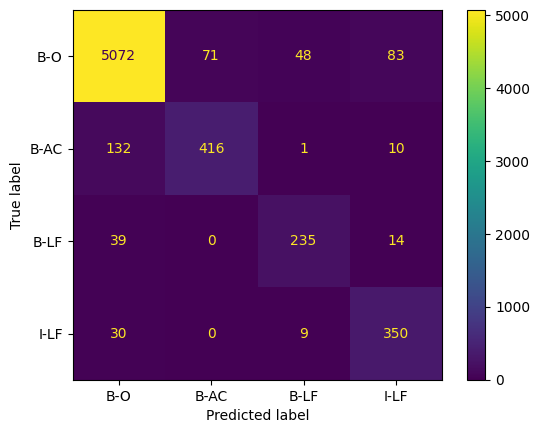

In [ ]:
# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_test_roberta)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out reports
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()

##### Experiment 4.1c SGD Optimizer

In [ ]:
# Import tokenizer, model, and data collator
epochs = 6
batch_size = 4
learning_rate = 1e-5

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Intialize the SGD optimizer
sgd_optimizer = SGD(model.parameters(), learning_rate, momentum=0.9)  # Example learning rate and momentum

SGD_args = TrainingArguments(
    f"BERT-SGD-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    SGD_args,
    train_dataset=ready_train_roberta,
    eval_dataset=ready_val_roberta,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
    optimizers=(sgd_optimizer, None)
)
trainer.train()

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=1.0666254100514883, metrics={'train_runtime': 67.0903, 'train_samples_per_second': 95.871, 'train_steps_per_second': 23.968, 'total_flos': 272841616431072.0, 'train_loss': 1.0666254100514883, 'epoch': 6.0})

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344

              precision    recall  f1-score   support

         B-O       0.81      1.00      0.90      5274
        B-AC       0.00      0.00      0.00       559
        B-LF       0.00      0.00      0.00       288
        I-LF       0.00      0.00      0.00       389

    accuracy                           0.81      6510
   macro avg       0.20      0.25      0.22      6510
weighted avg       0.66      0.81      0.73      6510

0.8101382488479263
0.7251644814025735
[[5274    0    0    0]
 [ 559    0    0    0]
 [ 288    0    0    0]
 [ 389    0    0    0]]


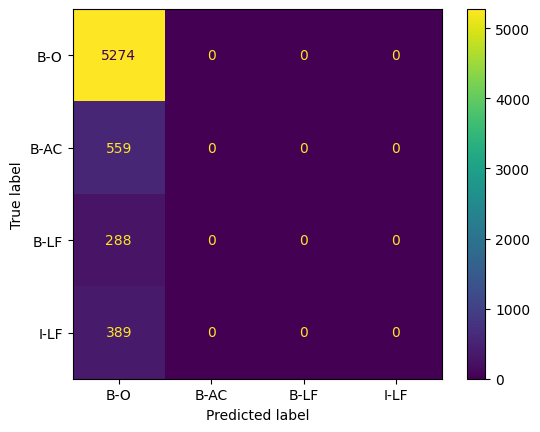

In [ ]:
# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_test_roberta)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out reports
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()

##### Experiment 4.1d Adam Optimizer

In [ ]:


# Import tokenizer, model, and data collator
epochs = 6
batch_size = 4
learning_rate = 1e-5

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Initialize adam optimizer
adam_optimizer = Adam(model.parameters(), learning_rate)

Adam_args = TrainingArguments(
    f"BERT-Adam-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    Adam_args,
    train_dataset=ready_train_roberta,
    eval_dataset=ready_val_roberta,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
    optimizers=(adam_optimizer, None)
)
trainer.train()

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.20194076483522483, metrics={'train_runtime': 74.7362, 'train_samples_per_second': 86.063, 'train_steps_per_second': 21.516, 'total_flos': 272841616431072.0, 'train_loss': 0.20194076483522483, 'epoch': 6.0})

              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5274
        B-AC       0.82      0.85      0.83       559
        B-LF       0.74      0.87      0.80       288
        I-LF       0.79      0.92      0.85       389

    accuracy                           0.94      6510
   macro avg       0.83      0.90      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.9370199692780338
0.9383673176396337
[[5017  102   79   76]
 [  81  474    2    2]
 [  22    0  250   16]
 [  22    2    6  359]]


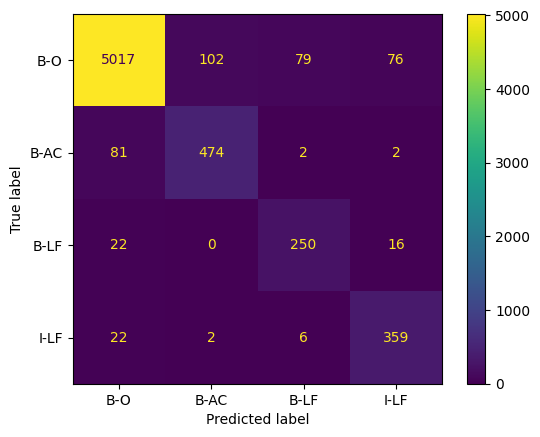

In [ ]:
# Code to generate predictions and labels
predictions, labels, _ = trainer.predict(ready_test_roberta)

predictions = np.argmax(predictions, axis=2)


# Remove the predictions for the [CLS] and [SEP] tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

final_predictions = [y for sublist in true_predictions for y in sublist]
final_labels = [y for sublist in true_labels for y in sublist]

# Print out reports
print(classification_report(final_labels, final_predictions, labels=label_list))
print(accuracy_score(final_labels, final_predictions))
print(f1_score(final_labels, final_predictions, average='weighted'))
print(confusion_matrix(final_labels, final_predictions, labels=label_list))

cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
cmd.plot()

### Experiment 4.2 Learning Rate Tuning


[I 2024-04-25 03:19:39,204] A new study created in memory with name: no-name-e397c6e0-014d-4355-baa5-4db795cd711e
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


[I 2024-04-25 03:22:18,388] Trial 0 finished with value: 0.9234885352879341 and parameters: {'learning_rate': 1e-06}. Best is trial 0 with value: 0.9234885352879341.


              precision    recall  f1-score   support

         B-O       0.98      0.94      0.96      5274
        B-AC       0.74      0.85      0.79       559
        B-LF       0.72      0.74      0.73       288
        I-LF       0.71      0.94      0.81       389

    accuracy                           0.92      6510
   macro avg       0.79      0.87      0.82      6510
weighted avg       0.93      0.92      0.92      6510

0.9208909370199693
0.9234885352879341
[[4942  160   74   98]
 [  79  476    2    2]
 [  23    1  212   52]
 [  15    4    5  365]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344

              precision    recall  f1-score   support

         B-O       0.81      1.00      0.90      5274
        B-AC       0.00      0.00      0.00       559
        B-LF       0.00      0.00      0.00       288
        I-LF       0.00      0.00      0.00       389

    accuracy                           0.81      6510
   macro avg       0.20      0.25      0.22      6510
weighted avg       0.66      0.81      0.73      6510

0.8101382488479263
0.7251644814025735
[[5274    0    0    0]
 [ 559    0    0    0]
 [ 288    0    0    0]
 [ 389    0    0    0]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344

              precision    recall  f1-score   support

         B-O       0.81      1.00      0.90      5274
        B-AC       0.00      0.00      0.00       559
        B-LF       0.00      0.00      0.00       288
        I-LF       0.00      0.00      0.00       389

    accuracy                           0.81      6510
   macro avg       0.20      0.25      0.22      6510
weighted avg       0.66      0.81      0.73      6510

0.8101382488479263
0.7251644814025735
[[5274    0    0    0]
 [ 559    0    0    0]
 [ 288    0    0    0]
 [ 389    0    0    0]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


[I 2024-04-25 03:30:08,568] Trial 3 finished with value: 0.942267676507351 and parameters: {'learning_rate': 1e-05}. Best is trial 3 with value: 0.942267676507351.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5274
        B-AC       0.86      0.82      0.84       559
        B-LF       0.77      0.86      0.81       288
        I-LF       0.78      0.93      0.85       389

    accuracy                           0.94      6510
   macro avg       0.85      0.89      0.87      6510
weighted avg       0.94      0.94      0.94      6510

0.9414746543778801
0.942267676507351
[[5061   66   66   81]
 [  95  457    5    2]
 [  23    0  248   17]
 [  15    6    5  363]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


[I 2024-04-25 03:32:46,079] Trial 4 finished with value: 0.9340109713048913 and parameters: {'learning_rate': 0.0001}. Best is trial 3 with value: 0.942267676507351.


              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5274
        B-AC       0.79      0.88      0.83       559
        B-LF       0.74      0.80      0.77       288
        I-LF       0.77      0.88      0.82       389

    accuracy                           0.93      6510
   macro avg       0.82      0.88      0.85      6510
weighted avg       0.94      0.93      0.93      6510

0.9324116743471582
0.9340109713048913
[[5003  128   64   79]
 [  60  494    3    2]
 [  39    0  230   19]
 [  26    6   14  343]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344

              precision    recall  f1-score   support

         B-O       0.81      1.00      0.90      5274
        B-AC       0.00      0.00      0.00       559
        B-LF       0.00      0.00      0.00       288
        I-LF       0.00      0.00      0.00       389

    accuracy                           0.81      6510
   macro avg       0.20      0.25      0.22      6510
weighted avg       0.66      0.81      0.73      6510

0.8101382488479263
0.7251644814025735
[[5274    0    0    0]
 [ 559    0    0    0]
 [ 288    0    0    0]
 [ 389    0    0    0]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344

              precision    recall  f1-score   support

         B-O       0.81      1.00      0.90      5274
        B-AC       0.00      0.00      0.00       559
        B-LF       0.00      0.00      0.00       288
        I-LF       0.00      0.00      0.00       389

    accuracy                           0.81      6510
   macro avg       0.20      0.25      0.22      6510
weighted avg       0.66      0.81      0.73      6510

0.8101382488479263
0.7251644814025735
[[5274    0    0    0]
 [ 559    0    0    0]
 [ 288    0    0    0]
 [ 389    0    0    0]]
Best trial:
  F1 Score: 0.942267676507351
  Optimal Learning Rate: 1e-05


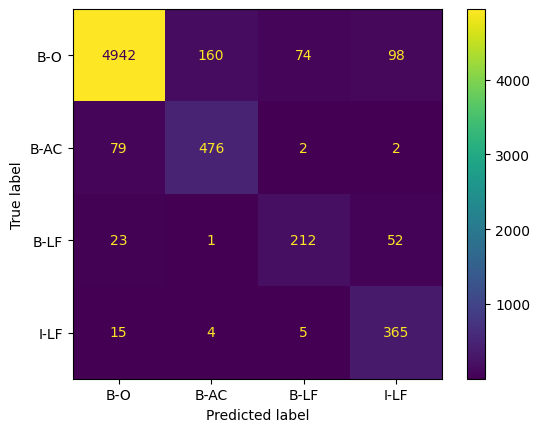

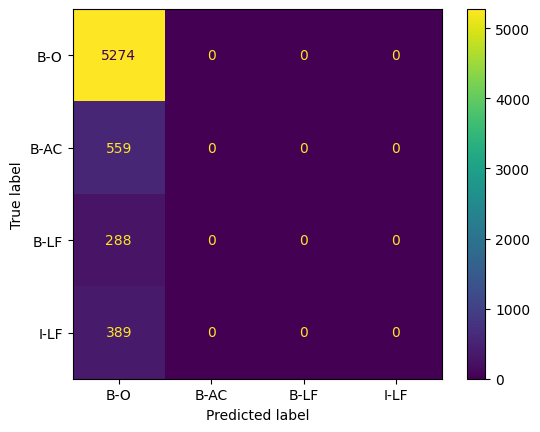

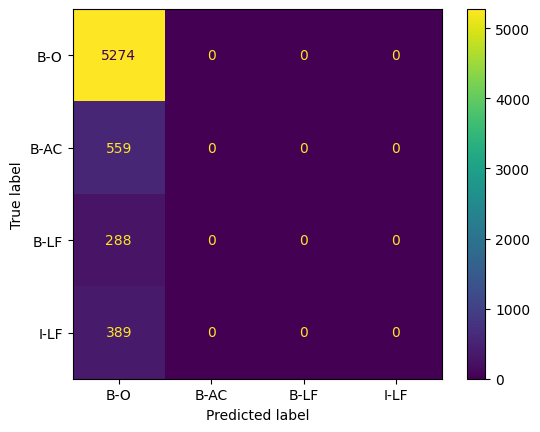

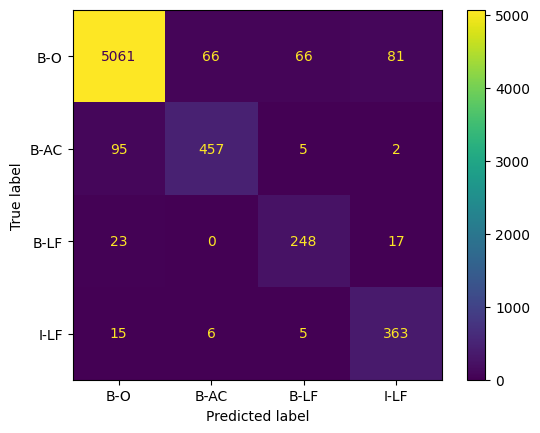

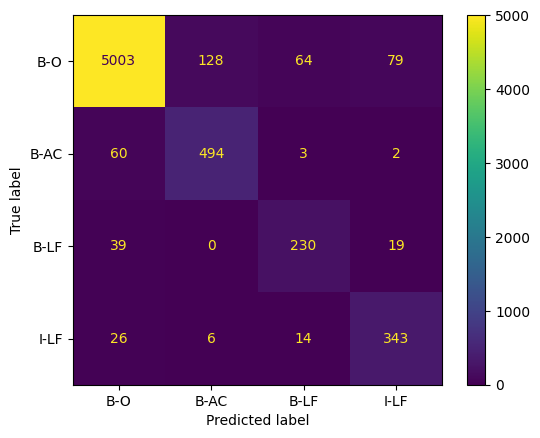

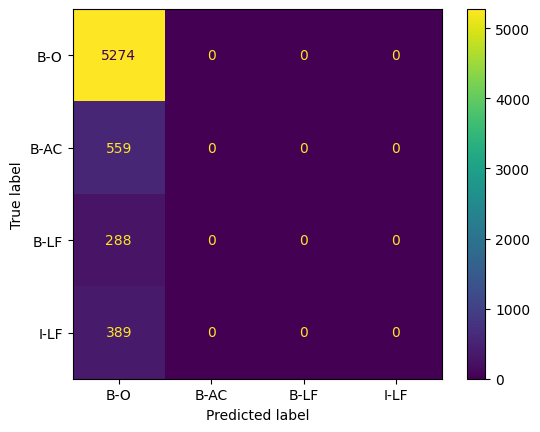

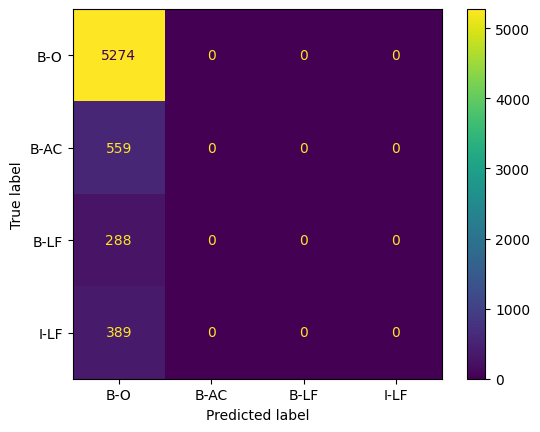

In [ ]:
# Set the learning rate values to be tested
learning_rate_values = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
sampler = GridSampler({"learning_rate": learning_rate_values})

def lr_objective(trial):
    # Suggest learning rate values
    learning_rate = trial.suggest_float("learning_rate", 1e-7,1e-1)

    # Training arguments (feel free to play arround with these values)
    epochs = 6
    batch_size = 4

    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

    data_collator = DataCollatorForTokenClassification(tokenizer)

    # Training arguments
    args = TrainingArguments(
        f"BERT-Hyperparameter-LR-NER",
        evaluation_strategy='steps',
        eval_steps=7000,
        save_total_limit=3,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.001,
        save_steps=35000,
        metric_for_best_model='f1',
        load_best_model_at_end=True,
        report_to='none'  # Avoid clutter
    )

    trainer = Trainer(
        model,
        args,
        train_dataset=ready_train_roberta,
        eval_dataset=ready_val_roberta,
        data_collator = data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    )
    trainer.train()

    # Train the model
    trainer.train()

    # Test
    predictions, labels, _ = trainer.predict(ready_test_roberta)

    predictions = np.argmax(predictions, axis=2)

    # Remove the predictions for the [CLS] and [SEP] tokens
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    final_predictions = [y for sublist in true_predictions for y in sublist]
    final_labels = [y for sublist in true_labels for y in sublist]

    # Print out reports
    print(classification_report(final_labels, final_predictions, labels=label_list))
    print(accuracy_score(final_labels, final_predictions))
    print(f1_score(final_labels, final_predictions, average='weighted'))
    print(confusion_matrix(final_labels, final_predictions, labels=label_list))

    cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
    cmd.plot()


    return f1_score(final_labels, final_predictions, average='weighted')

# Create an optuna study to focus on the learning rate
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lr_objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print(f"  Optimal Learning Rate: {trial.params['learning_rate']}")

### Experiment 4.3 Epochs Tuning

[I 2024-04-25 03:38:01,113] A new study created in memory with name: no-name-bb0674c5-72b6-4613-8a20-f75999b7e33d
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:40:13,476] Trial 0 finished with value: 0.9328773464927274 and parameters: {'epochs': 10}. Best is trial 0 with value: 0.9328773464927274.


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5274
        B-AC       0.78      0.87      0.82       559
        B-LF       0.73      0.78      0.75       288
        I-LF       0.80      0.86      0.83       389

    accuracy                           0.93      6510
   macro avg       0.82      0.86      0.84      6510
weighted avg       0.94      0.93      0.93      6510

0.9314900153609831
0.9328773464927274
[[5019  136   57   62]
 [  63  487    6    3]
 [  42    1  224   21]
 [  31    3   21  334]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:41:59,028] Trial 1 finished with value: 0.9335668469934856 and parameters: {'epochs': 8}. Best is trial 1 with value: 0.9335668469934856.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5274
        B-AC       0.78      0.85      0.81       559
        B-LF       0.78      0.82      0.80       288
        I-LF       0.81      0.84      0.82       389

    accuracy                           0.93      6510
   macro avg       0.83      0.86      0.85      6510
weighted avg       0.93      0.93      0.93      6510

0.9327188940092166
0.9335668469934856
[[5037  126   53   58]
 [  81  473    3    2]
 [  34    0  236   18]
 [  48    4   11  326]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:42:13,799] Trial 2 finished with value: 0.9366039986364969 and parameters: {'epochs': 1}. Best is trial 2 with value: 0.9366039986364969.


              precision    recall  f1-score   support

         B-O       0.96      0.97      0.96      5274
        B-AC       0.83      0.81      0.82       559
        B-LF       0.80      0.77      0.79       288
        I-LF       0.81      0.85      0.83       389

    accuracy                           0.94      6510
   macro avg       0.85      0.85      0.85      6510
weighted avg       0.94      0.94      0.94      6510

0.9367127496159754
0.9366039986364969
[[5090   86   43   55]
 [ 103  453    1    2]
 [  46    0  223   19]
 [  41    5   11  332]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:43:06,957] Trial 3 finished with value: 0.9340479564274558 and parameters: {'epochs': 4}. Best is trial 2 with value: 0.9366039986364969.


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5274
        B-AC       0.77      0.87      0.82       559
        B-LF       0.75      0.81      0.77       288
        I-LF       0.81      0.87      0.84       389

    accuracy                           0.93      6510
   macro avg       0.82      0.87      0.85      6510
weighted avg       0.94      0.93      0.93      6510

0.9325652841781874
0.9340479564274558
[[5013  144   56   61]
 [  67  488    2    2]
 [  37    1  232   18]
 [  27    3   21  338]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:43:34,165] Trial 4 finished with value: 0.9307261950010662 and parameters: {'epochs': 2}. Best is trial 2 with value: 0.9366039986364969.


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5274
        B-AC       0.78      0.87      0.82       559
        B-LF       0.75      0.73      0.74       288
        I-LF       0.78      0.84      0.81       389

    accuracy                           0.93      6510
   macro avg       0.82      0.85      0.83      6510
weighted avg       0.93      0.93      0.93      6510

0.929800307219662
0.9307261950010662
[[5030  138   48   58]
 [  68  484    2    5]
 [  47    0  211   30]
 [  42    0   19  328]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:44:40,458] Trial 5 finished with value: 0.9356065441316493 and parameters: {'epochs': 5}. Best is trial 2 with value: 0.9366039986364969.


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5274
        B-AC       0.80      0.87      0.84       559
        B-LF       0.72      0.82      0.76       288
        I-LF       0.80      0.84      0.82       389

    accuracy                           0.93      6510
   macro avg       0.82      0.87      0.85      6510
weighted avg       0.94      0.93      0.94      6510

0.9342549923195085
0.9356065441316493
[[5032  115   66   61]
 [  61  489    4    5]
 [  35    1  235   17]
 [  34    7   22  326]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:46:11,900] Trial 6 finished with value: 0.9381112720303435 and parameters: {'epochs': 7}. Best is trial 6 with value: 0.9381112720303435.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5274
        B-AC       0.82      0.86      0.84       559
        B-LF       0.76      0.80      0.78       288
        I-LF       0.79      0.86      0.83       389

    accuracy                           0.94      6510
   macro avg       0.84      0.87      0.85      6510
weighted avg       0.94      0.94      0.94      6510

0.9373271889400921
0.9381112720303435
[[5055  102   55   62]
 [  70  480    6    3]
 [  35    0  231   22]
 [  42    1   10  336]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:48:09,557] Trial 7 finished with value: 0.9358671199476586 and parameters: {'epochs': 9}. Best is trial 6 with value: 0.9381112720303435.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5274
        B-AC       0.79      0.85      0.82       559
        B-LF       0.77      0.79      0.78       288
        I-LF       0.83      0.85      0.84       389

    accuracy                           0.94      6510
   macro avg       0.84      0.86      0.85      6510
weighted avg       0.94      0.94      0.94      6510

0.9351766513056836
0.9358671199476586
[[5054  123   47   50]
 [  76  477    4    2]
 [  47    0  227   14]
 [  36    5   18  330]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:48:50,611] Trial 8 finished with value: 0.9389660469215844 and parameters: {'epochs': 3}. Best is trial 8 with value: 0.9389660469215844.


              precision    recall  f1-score   support

         B-O       0.98      0.96      0.97      5274
        B-AC       0.80      0.87      0.83       559
        B-LF       0.77      0.82      0.79       288
        I-LF       0.79      0.89      0.84       389

    accuracy                           0.94      6510
   macro avg       0.83      0.88      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.9377880184331797
0.9389660469215844
[[5039  114   52   69]
 [  69  485    2    3]
 [  34    0  235   19]
 [  20    7   16  346]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 03:50:09,698] Trial 9 finished with value: 0.9397657729455244 and parameters: {'epochs': 6}. Best is trial 9 with value: 0.9397657729455244.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5274
        B-AC       0.82      0.85      0.83       559
        B-LF       0.77      0.84      0.80       288
        I-LF       0.82      0.87      0.85       389

    accuracy                           0.94      6510
   macro avg       0.84      0.88      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.9390168970814132
0.9397657729455244
[[5060  102   58   54]
 [  80  474    3    2]
 [  30    0  241   17]
 [  35    4   12  338]]
Best trial:
  F1 Score: 0.9397657729455244
  Optimal Epochs: 6


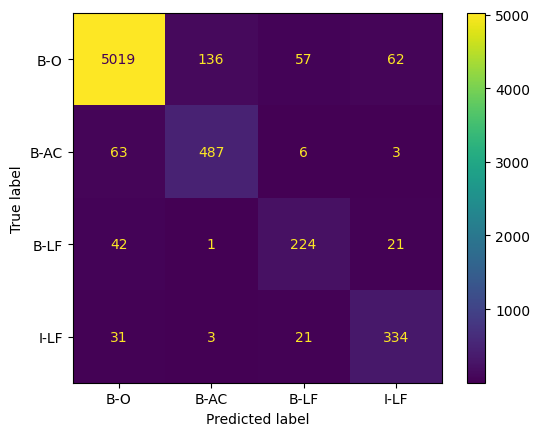

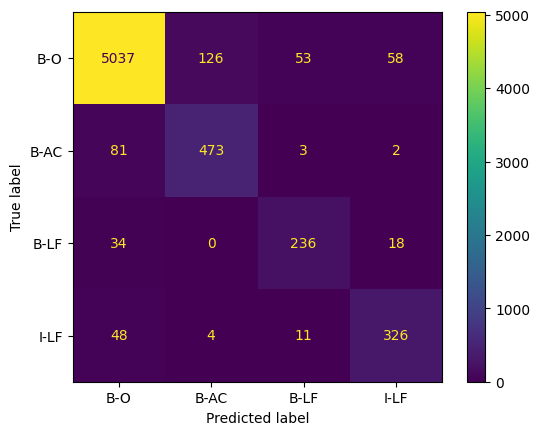

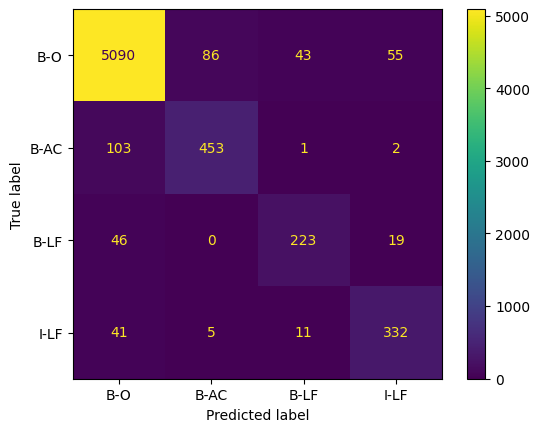

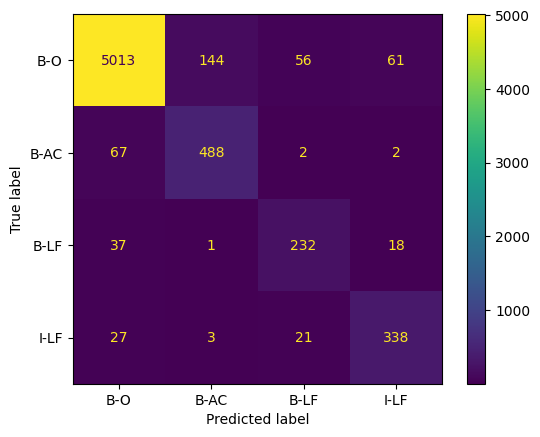

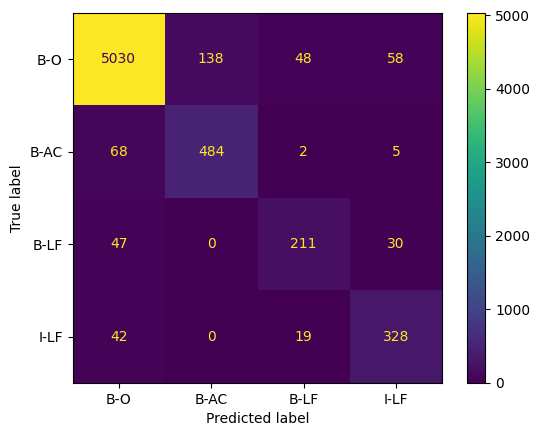

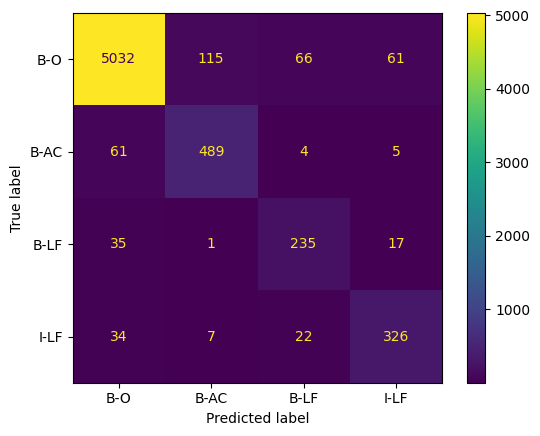

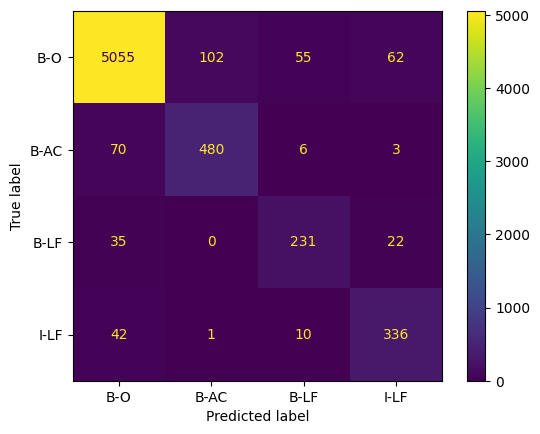

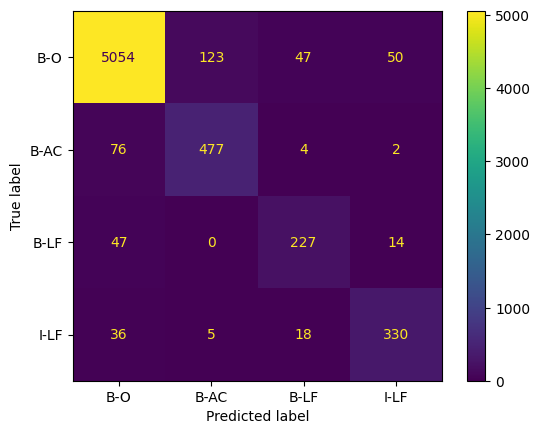

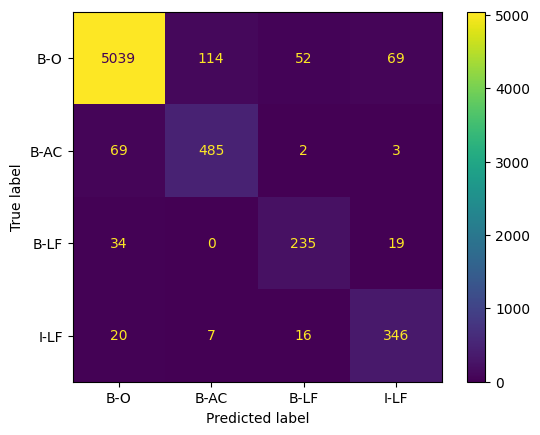

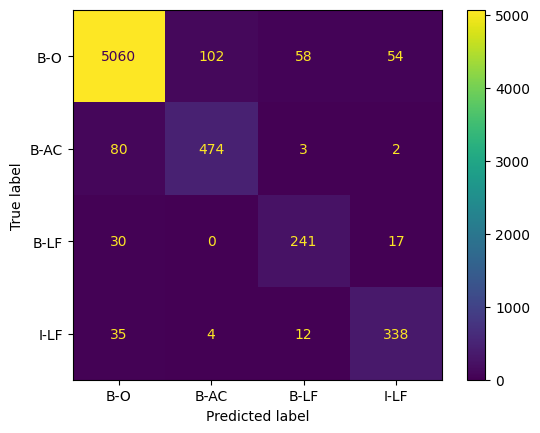

In [ ]:
# Set the epoch values to be tested
sampler = GridSampler({"epochs": list(range(1, 11))})
def epochs_objective(trial):
    # Training arguments (feel free to play arround with these values)
    model_name = "bert-base-cased"
    epochs = trial.suggest_int("epochs", 1, 10)
    batch_size = 4
    learning_rate = 1e-5

    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

    data_collator = DataCollatorForTokenClassification(tokenizer)

    # Training arguments
    args = TrainingArguments(
        f"BERT-Hyperparameter-Epochs-NER",
        evaluation_strategy='steps',
        eval_steps=7000,
        save_total_limit=3,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.001,
        save_steps=35000,
        metric_for_best_model='f1',
        load_best_model_at_end=True,
        report_to='none'  # Avoid clutter
    )

    trainer = Trainer(
        model,
        args,
        train_dataset=ready_train_roberta,
        eval_dataset=ready_val_roberta,
        data_collator = data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    )
    trainer.train()

    # Test
    predictions, labels, _ = trainer.predict(ready_test_roberta)

    predictions = np.argmax(predictions, axis=2)

    # Remove the predictions for the [CLS] and [SEP] tokens
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]


    final_predictions = [y for sublist in true_predictions for y in sublist]
    final_labels = [y for sublist in true_labels for y in sublist]

    # Print out reports
    print(classification_report(final_labels, final_predictions, labels=label_list))
    print(accuracy_score(final_labels, final_predictions))
    print(f1_score(final_labels, final_predictions, average='weighted'))
    print(confusion_matrix(final_labels, final_predictions, labels=label_list))

    cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
    cmd.plot()

    return f1_score(final_labels, final_predictions, average='weighted')

# Create an optuna study to focus on the epochs
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(epochs_objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print(f"  Optimal Epochs: {trial.params['epochs']}")


### Experiment 4.4 Batch Size Tuning

[I 2024-04-25 04:51:12,162] A new study created in memory with name: no-name-ce8a8d7d-bc67-4a91-99f6-e9bc998e0d14
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 04:56:06,188] Trial 0 finished with value: 0.9392125244347961 and parameters: {'batch_size': 1}. Best is trial 0 with value: 0.9392125244347961.


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5274
        B-AC       0.84      0.84      0.84       559
        B-LF       0.76      0.86      0.81       288
        I-LF       0.78      0.92      0.84       389

    accuracy                           0.94      6510
   macro avg       0.84      0.89      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.9380952380952381
0.9392125244347961
[[5035   85   69   85]
 [  89  467    1    2]
 [  23    1  248   16]
 [  20    3    9  357]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 04:57:12,347] Trial 1 finished with value: 0.9408136067474206 and parameters: {'batch_size': 5}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.98      0.96      0.97      5274
        B-AC       0.81      0.85      0.83       559
        B-LF       0.79      0.86      0.83       288
        I-LF       0.80      0.91      0.85       389

    accuracy                           0.94      6510
   macro avg       0.84      0.90      0.87      6510
weighted avg       0.94      0.94      0.94      6510

0.9397849462365592
0.9408136067474206
[[5039  107   56   72]
 [  79  476    2    2]
 [  24    0  249   15]
 [  25    2    8  354]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 04:59:43,261] Trial 2 finished with value: 0.9400100972605412 and parameters: {'batch_size': 2}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5274
        B-AC       0.84      0.84      0.84       559
        B-LF       0.76      0.85      0.80       288
        I-LF       0.79      0.92      0.85       389

    accuracy                           0.94      6510
   macro avg       0.84      0.89      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.9390168970814132
0.9400100972605412
[[5041   88   70   75]
 [  86  469    2    2]
 [  26    1  245   16]
 [  22    3    6  358]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 05:00:42,941] Trial 3 finished with value: 0.9397640744478335 and parameters: {'batch_size': 6}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.96      5274
        B-AC       0.82      0.84      0.83       559
        B-LF       0.79      0.85      0.82       288
        I-LF       0.79      0.90      0.84       389

    accuracy                           0.94      6510
   macro avg       0.84      0.89      0.87      6510
weighted avg       0.94      0.94      0.94      6510

0.938863287250384
0.9397640744478335
[[5045  101   57   71]
 [  85  470    2    2]
 [  24    0  246   18]
 [  29    2    7  351]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 05:01:34,680] Trial 4 finished with value: 0.9351000196221211 and parameters: {'batch_size': 9}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5274
        B-AC       0.81      0.84      0.82       559
        B-LF       0.74      0.84      0.79       288
        I-LF       0.78      0.90      0.84       389

    accuracy                           0.93      6510
   macro avg       0.83      0.88      0.85      6510
weighted avg       0.94      0.93      0.94      6510

0.9337941628264209
0.9351000196221211
[[5015  106   77   76]
 [  87  469    1    2]
 [  24    1  243   20]
 [  28    2    7  352]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 05:02:53,301] Trial 5 finished with value: 0.9383673176396337 and parameters: {'batch_size': 4}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5274
        B-AC       0.82      0.85      0.83       559
        B-LF       0.74      0.87      0.80       288
        I-LF       0.79      0.92      0.85       389

    accuracy                           0.94      6510
   macro avg       0.83      0.90      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.9370199692780338
0.9383673176396337
[[5017  102   79   76]
 [  81  474    2    2]
 [  22    0  250   16]
 [  22    2    6  359]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 05:03:50,131] Trial 6 finished with value: 0.936547469403684 and parameters: {'batch_size': 7}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.97      0.95      0.96      5274
        B-AC       0.81      0.84      0.82       559
        B-LF       0.76      0.87      0.81       288
        I-LF       0.78      0.91      0.84       389

    accuracy                           0.94      6510
   macro avg       0.83      0.89      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.9351766513056836
0.936547469403684
[[5015  108   70   81]
 [  86  470    1    2]
 [  19    1  250   18]
 [  24    2   10  353]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 05:04:41,303] Trial 7 finished with value: 0.9349326962063332 and parameters: {'batch_size': 10}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5274
        B-AC       0.79      0.85      0.82       559
        B-LF       0.75      0.86      0.80       288
        I-LF       0.78      0.92      0.84       389

    accuracy                           0.93      6510
   macro avg       0.82      0.89      0.86      6510
weighted avg       0.94      0.93      0.93      6510

0.9333333333333333
0.9349326962063332
[[4996  125   73   80]
 [  81  475    1    2]
 [  22    0  249   17]
 [  22    3    8  356]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 05:06:23,554] Trial 8 finished with value: 0.9407830319199207 and parameters: {'batch_size': 3}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.97      0.96      0.97      5274
        B-AC       0.83      0.84      0.83       559
        B-LF       0.79      0.87      0.83       288
        I-LF       0.79      0.91      0.84       389

    accuracy                           0.94      6510
   macro avg       0.84      0.90      0.87      6510
weighted avg       0.94      0.94      0.94      6510

0.9397849462365592
0.9407830319199207
[[5041   96   58   79]
 [  83  472    2    2]
 [  21    1  250   16]
 [  26    3    5  355]]


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


[I 2024-04-25 05:07:16,763] Trial 9 finished with value: 0.9378444822009464 and parameters: {'batch_size': 8}. Best is trial 1 with value: 0.9408136067474206.


              precision    recall  f1-score   support

         B-O       0.98      0.95      0.96      5274
        B-AC       0.80      0.85      0.82       559
        B-LF       0.76      0.87      0.81       288
        I-LF       0.79      0.93      0.85       389

    accuracy                           0.94      6510
   macro avg       0.83      0.90      0.86      6510
weighted avg       0.94      0.94      0.94      6510

0.936405529953917
0.9378444822009464
[[5009  119   72   74]
 [  78  477    2    2]
 [  20    0  250   18]
 [  22    2    5  360]]
Best trial:
  F1 Score: 0.9408136067474206
  Optimal Batch Size: 5


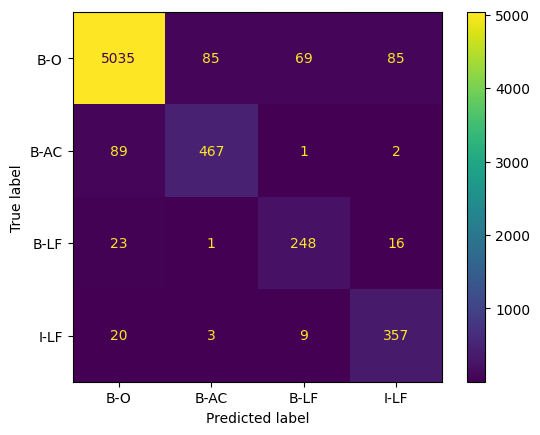

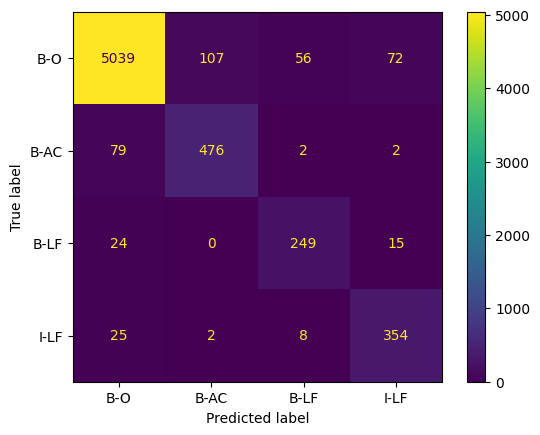

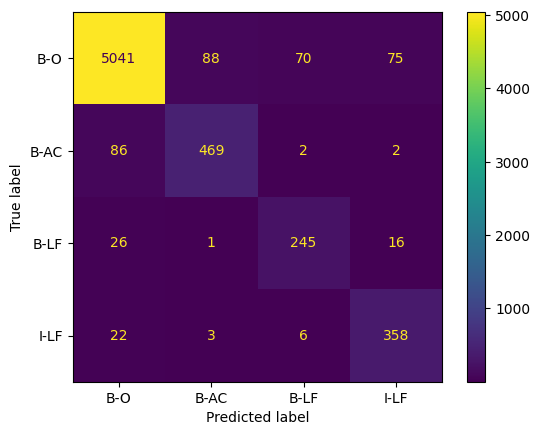

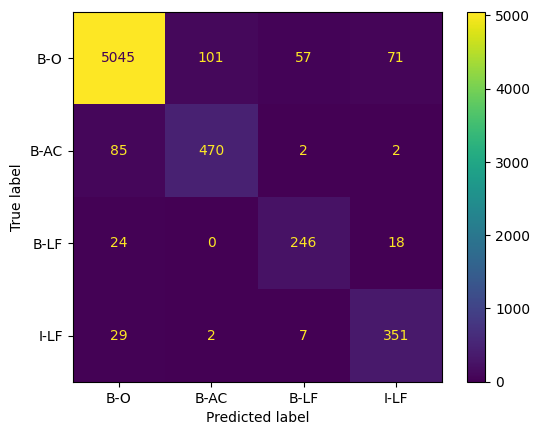

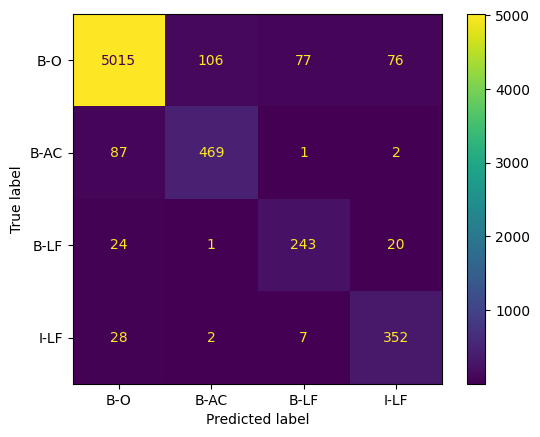

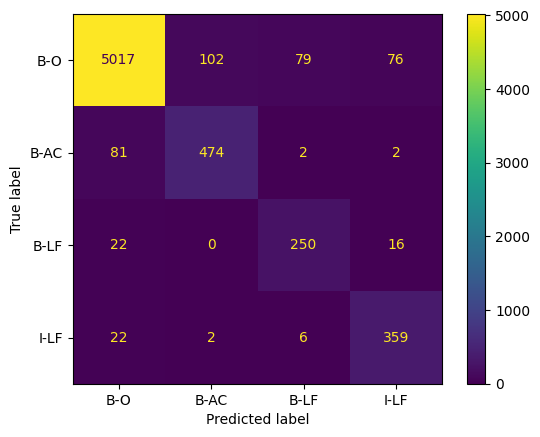

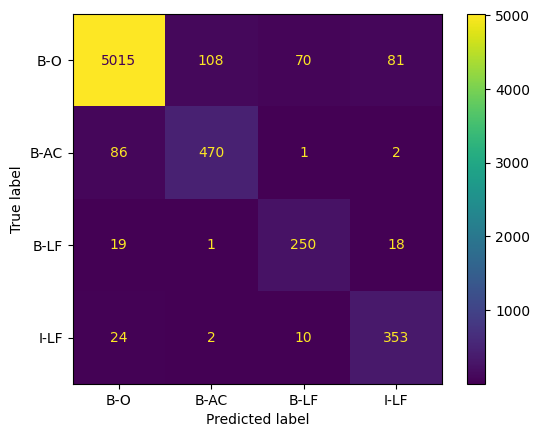

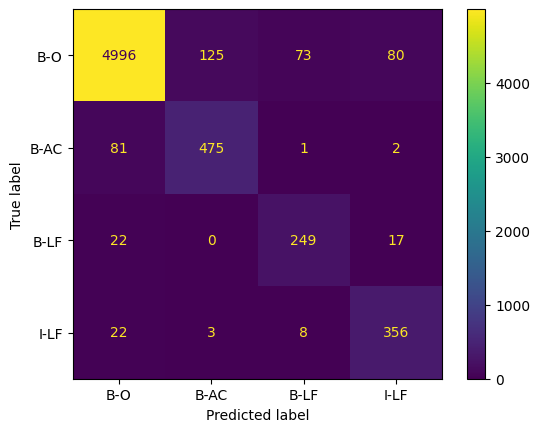

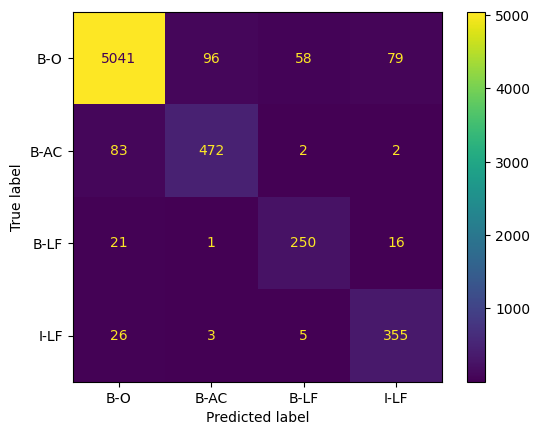

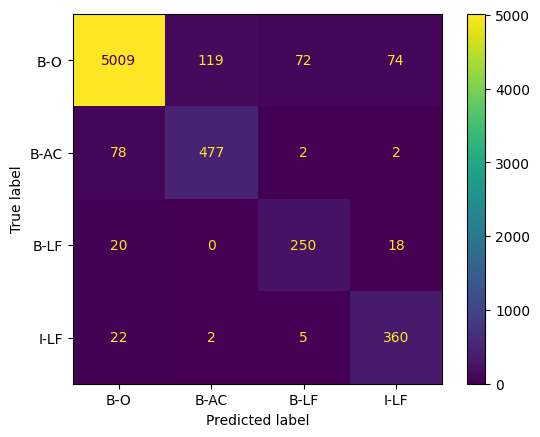

In [ ]:
# Set the batch sizes to be tested
sampler = GridSampler({"batch_size": list(range(1, 11))})
def batch_objective(trial):
    # Training arguments (feel free to play arround with these values)
    model_name = "bert-base-cased"
    epochs = 6
    batch_size = trial.suggest_int("batch_size", 1, 10)
    learning_rate = 1e-5

    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

    data_collator = DataCollatorForTokenClassification(tokenizer)

    # Training arguments
    args = TrainingArguments(
        f"BERT-Hyperparameter-Epochs-NER",
        evaluation_strategy='steps',
        eval_steps=7000,
        save_total_limit=3,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.001,
        save_steps=35000,
        metric_for_best_model='f1',
        load_best_model_at_end=True,
        report_to='none'  # Avoid clutter
    )

    trainer = Trainer(
        model,
        args,
        train_dataset=ready_train_roberta,
        eval_dataset=ready_val_roberta,
        data_collator = data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    )
    trainer.train()

    # Test
    predictions, labels, _ = trainer.predict(ready_test_roberta)

    predictions = np.argmax(predictions, axis=2)

    # Remove the predictions for the [CLS] and [SEP] tokens
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    final_predictions = [y for sublist in true_predictions for y in sublist]
    final_labels = [y for sublist in true_labels for y in sublist]

    # Print out reports
    print(classification_report(final_labels, final_predictions, labels=label_list))
    print(accuracy_score(final_labels, final_predictions))
    print(f1_score(final_labels, final_predictions, average='weighted'))
    print(confusion_matrix(final_labels, final_predictions, labels=label_list))

    cmd = ConfusionMatrixDisplay(confusion_matrix(final_labels, final_predictions, labels=label_list), display_labels=label_list)
    cmd.plot()

    return f1_score(final_labels, final_predictions, average='weighted')

# Create an optuna study to focus on the batch sizes
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(batch_objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print(f"  Optimal Batch Size: {trial.params['batch_size']}")

### Experiment 4.1 Results Visualization

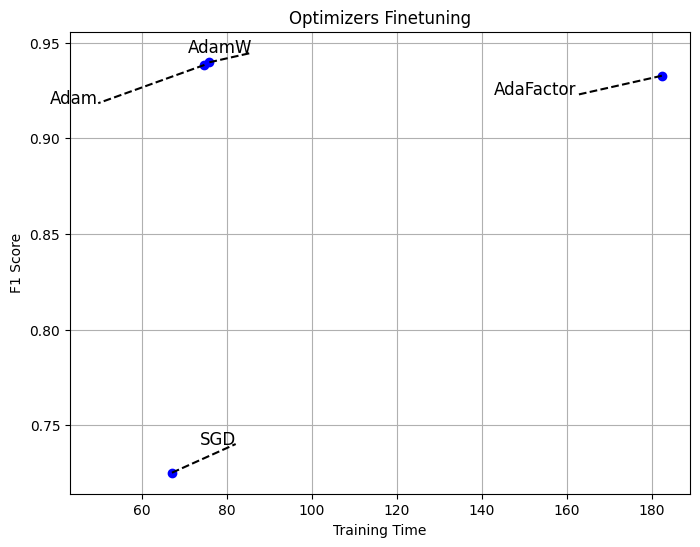

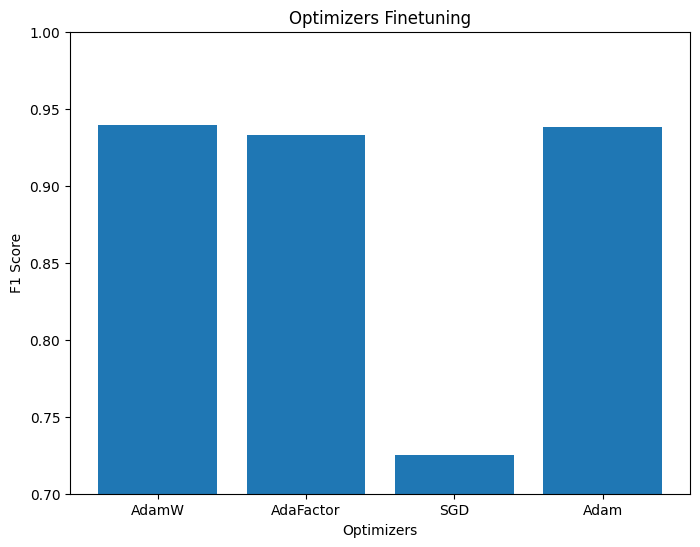

In [ ]:
# Data for experiment
train_runtime = [75.9016, 182.3748, 67.0903, 74.7362]
f1_scores = [0.9397511299120602,0.9327128926811712,0.7251644814025735, 0.9383673176396337]

# Names of the different experiments/models
model_names = ['AdamW', 'AdaFactor', 'SGD', 'Adam']

# Create plot and plot the data
plt.figure(figsize=(8, 6))
plt.scatter(train_runtime, f1_scores, color='b', label='Optimizers')

# Offsets for text
offsets = [10, -20, 15, -25]
y_offsets = [0.005, -0.01, 0.015, -0.02]

for i in range(len(model_names)):
    plt.text(
        train_runtime[i] + offsets[i],
        f1_scores[i] + y_offsets[i],
        model_names[i],
        fontsize=12,
        ha='right'
    )
    plt.plot(
        [train_runtime[i], train_runtime[i] + offsets[i]],
        [f1_scores[i], f1_scores[i] + y_offsets[i]],
        color='black',
         linestyle='--'
    )

# Label the graph
plt.xlabel('Training Time')
plt.ylabel('F1 Score')
plt.title('Optimizers Finetuning')
plt.grid(True)
plt.show()


# Bar chart for f1 scores
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores)
plt.ylim(0.7,1)

# Label bar graph
plt.xlabel('Optimizers')
plt.ylabel('F1 Score')
plt.title('Optimizers Finetuning')
plt.show()


### Experiment 4.2 Results Visualization

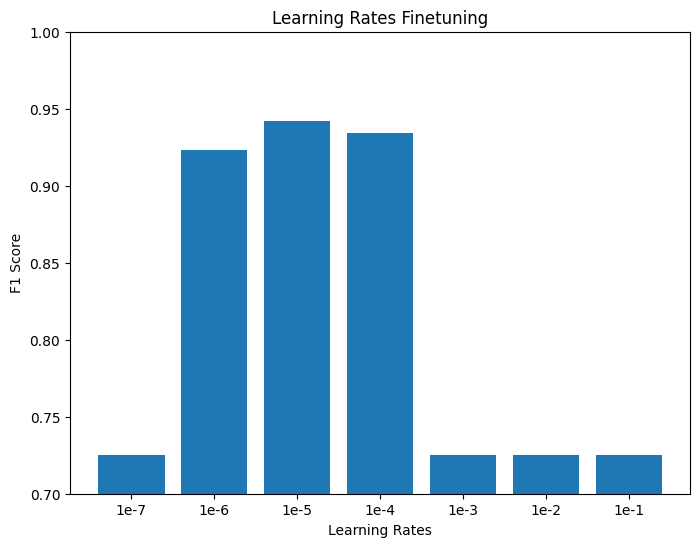

In [ ]:
# Data for experiment
f1_scores = [0.7251644814025735,0.9234885352879341,0.942267676507351,0.9340109713048913,0.7251644814025735,0.7251644814025735,0.7251644814025735]

# Names of the different experiments/models
model_names = ['1e-7','1e-6','1e-5','1e-4','1e-3','1e-2','1e-1']

# Bar chart for f1 scores
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores)
plt.ylim(0.7,1)

# Label bar graph
plt.xlabel('Learning Rates')
plt.ylabel('F1 Score')
plt.title('Learning Rates Finetuning')
plt.show()


### Experiment 4.3 Results Visualization

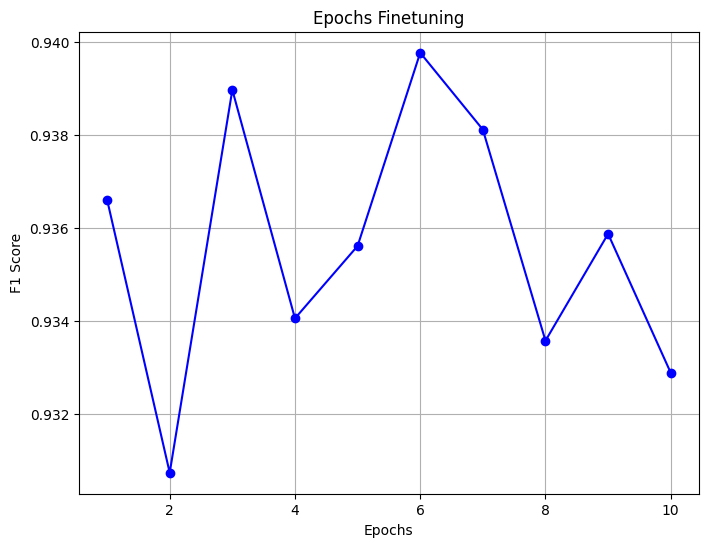

In [ ]:
# Data for experiment
train_runtime = [12,25,38,51,64,76,89,103,115,130]
f1_scores = [0.9366039986364969,0.9307261950010662,0.9389660469215844,0.9340479564274558,0.9356065441316493,0.9397657729455244,0.9381112720303435,0.9335668469934856,0.9358671199476586,0.9328773464927274]
epochs =[1,2,3,4,5,6,7,8,9,10]
# Names of the different experiments/models
model_names = ['1','2','3','4','5','6','7','8','9','10']

# Line graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='b')

# Label the graph
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Epochs Finetuning')
plt.grid(True)
plt.show()

### Experiment 4.4 Results Visualization

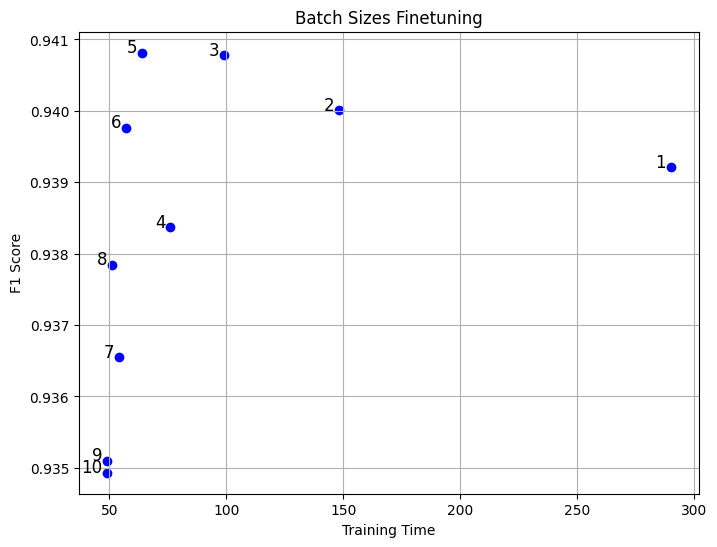

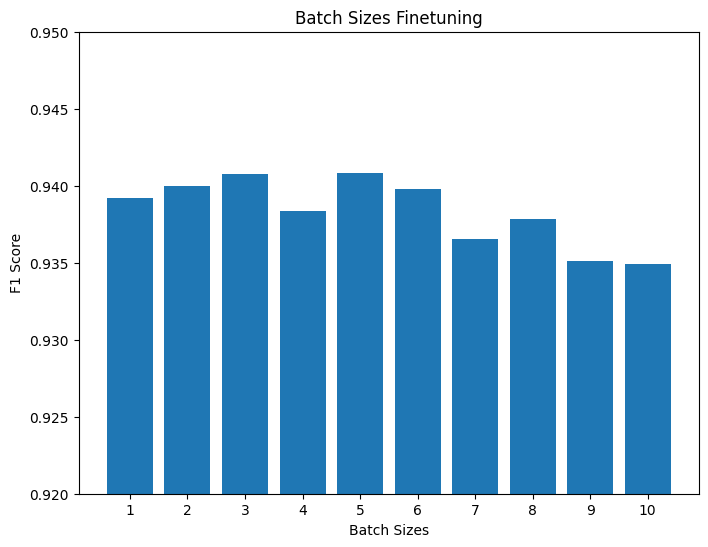

In [ ]:
# Data for experiment
train_runtime = [290,148,99,76,64,57,54,51,49,49]
f1_scores = [0.9392125244347961,0.9400100972605412,0.9407830319199207,0.9383673176396337,0.9408136067474206,0.9397640744478335,0.936547469403684,0.9378444822009464,0.9351000196221211,0.9349326962063332]

# Names of the different experiments/models
model_names = ['1','2','3','4','5','6','7','8','9','10']

# Create plot and plot the data
plt.figure(figsize=(8, 6))
plt.scatter(train_runtime, f1_scores, color='b', label='Optimizers')
for i in range(10):
    plt.text(train_runtime[i]-2, f1_scores[i], model_names[i], fontsize=12, ha='right')

# Label the graph
plt.xlabel('Training Time')
plt.ylabel('F1 Score')
plt.title('Batch Sizes Finetuning')
plt.grid(True)
plt.show()

# Bar chart for f1 scores
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores)
plt.ylim(0.92,0.95)

# Label bar graph
plt.xlabel('Batch Sizes')
plt.ylabel('F1 Score')
plt.title('Batch Sizes Finetuning')
plt.show()
